# Analysis Lab Notebook for Hyperparameter Search Regime I

This notebook contains the preliminary analysis for the hyperparameter search regime I data. This is a 'lab' notebook, and hence it is meant as as a walkthrough of the initial exploration process.

## Load Libraries

In [1]:
import pickle
import csv
import matplotlib.pyplot as plt
import pandas as pd

# Import utility functions defined in ../common/ package
import sys
sys.path.append('../')
from common import *

2023-04-04 23:58:15.360179: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-04 23:58:15.467267: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-04 23:58:15.470108: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-04 23:58:15.470121: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

## Load Raw Data for Analysis

In [2]:
try:
    with open('regime-1-raw-data.pickle', 'rb') as handle:
        hypersearch_data = pickle.load(handle)
    print(f"Hyperparameter search results with {len(hypersearch_data)} entries found.")
except FileNotFoundError as e:
    print("Raw data for analysis not found.")

Hyperparameter search results with 110 entries found.


## Utility Functions for Analysis

In [3]:
def to_csv(kfold_metrics_list, filename: str, metric: str = 'val_auc', header: bool = True) -> None:
    folds : int = len(kfold_metrics_list)
    epochs: int = len(kfold_metrics_list[0]['val_auc'])
    """
    Writes k-fold cross-validation metrics to a CSV file.

    Args:
        kfold_metrics_list (List[Dict]): List of dictionaries containing k-fold cross-validation metrics.
        filename (str): The name of the CSV file to be created.
        metric (str, optional): The name of the metric to be written to the CSV file. Defaults to 'val_auc'.
        header (bool, optional): Whether to write a header row in the CSV file. Defaults to True.

    Returns:
        None
    """
    with open(filename, 'w') as csvfile:
        
        writer = csv.writer(csvfile)

        if header:
            header: list = ["epochs"] + [f"fold{x+1}" for x in range(folds)] + ['avg']
            writer.writerow(header)

        for epoch in range(epochs):
            values_per_epoch: list[float] = [x[metric][epoch] for x in kfold_metrics_list]
            mean_per_epoch  : float = sum(values_per_epoch) / folds

            csv_row_list: list[float] = [epoch + 1] + values_per_epoch + [mean_per_epoch]

            writer.writerow(csv_row_list)

In [4]:
def sort_hypersearch_results(hypersearch_data):
    """
    Sorts the results of a hyperparameter search based on the average maximum metrics of each trial.

    Args:
        hypersearch_data (list[dict]): A list of dictionaries containing hyperparameter search results.
            Each dictionary represents a trial and should contain a 'history_list' key which contains
            a list of dictionaries representing the metrics of each fold in a k-fold cross-validation.

    Returns:
        sorted_hypersearch_data (list[dict]): A sorted list of dictionaries representing the hyperparameter search results, sorted in descending order based on the average maximum metrics of each trial.
    """
    max_avg_metrics : list[float] = []

    for i, trial in enumerate(hypersearch_data):
        trial_kfold_metrics = trial['history_list']
        max_avg_metrics.append(calculate_avg_max(trial_kfold_metrics))

    sorted_hypersearch_data: list[dict[str, float]] = [x for _,x in sorted(zip(max_avg_metrics, hypersearch_data), key=lambda x: x[0], reverse=True)]

    return sorted_hypersearch_data

# Analysis Code

In [5]:
sorted_metrics = sort_hypersearch_results(hypersearch_data)

Generate per-trial K-fold cross-validation metric-epoch graphs. This is just for preview, actual graphs will be made using TiKZ/PGFPlots in LaTeX.

In [6]:
def generate_graphs(sorted_metrics) -> None:
    for i, trial in enumerate(sorted_metrics):
        # Metrics that are graphed:
        trial_batch_size: int = trial['batch_size']
        trial_dropout_rate: float = round(trial['dropout_rate'], 3)
        trial_kfold: list[dict[str, float]] = trial['history_list']

        # Graph title
        title_str: str = f"Hyperparameter Trial {i + 1}/{len(sorted_metrics)}:\nValidation AUC:{round(calculate_avg_max(trial_kfold), 3)}\nBatch_size: {trial_batch_size}\nDropout: {trial_dropout_rate}"

        plot_kfold_history(trial_kfold, x_axis_max=19, title=title_str)

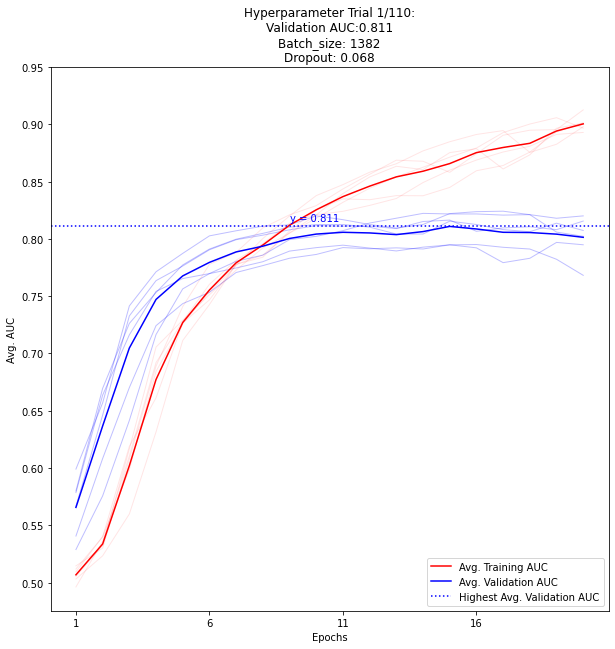

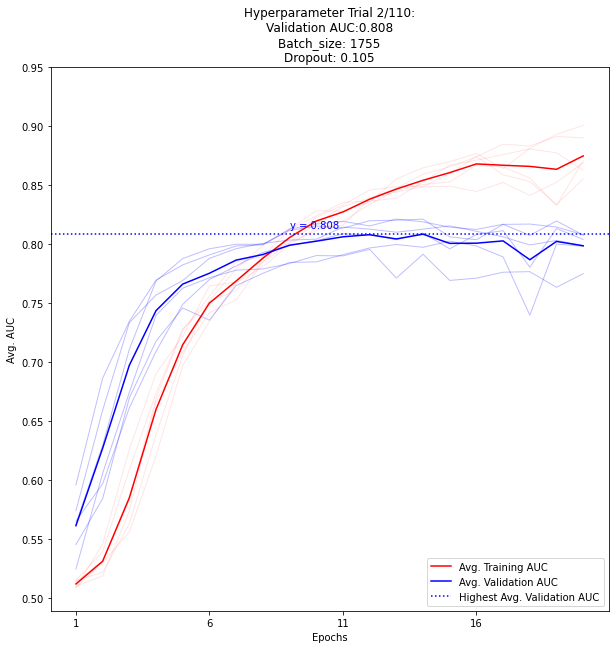

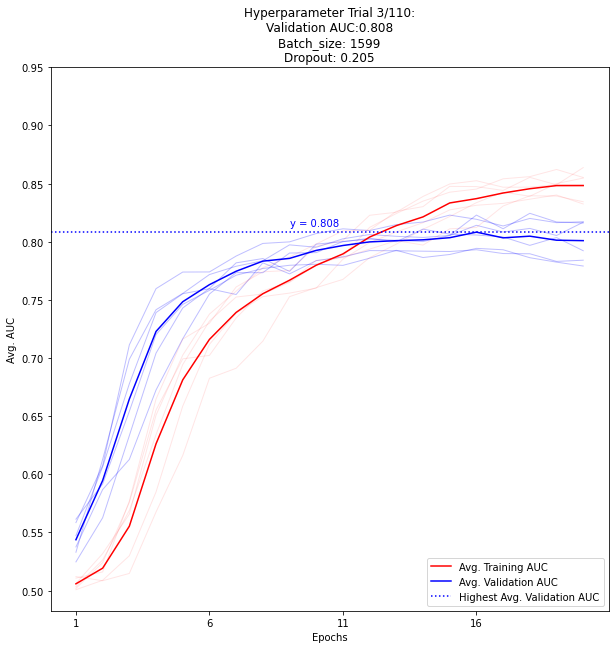

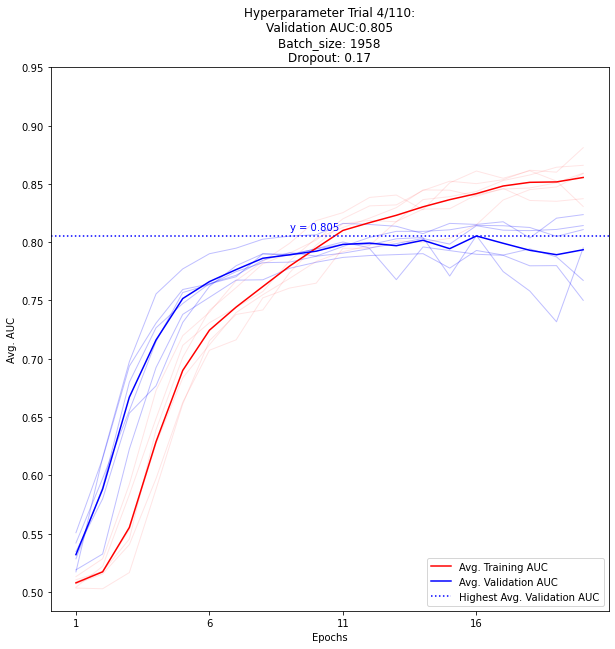

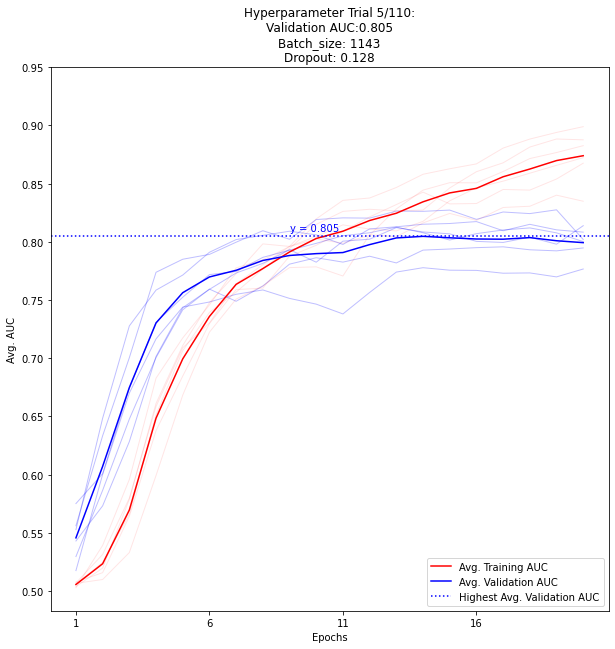

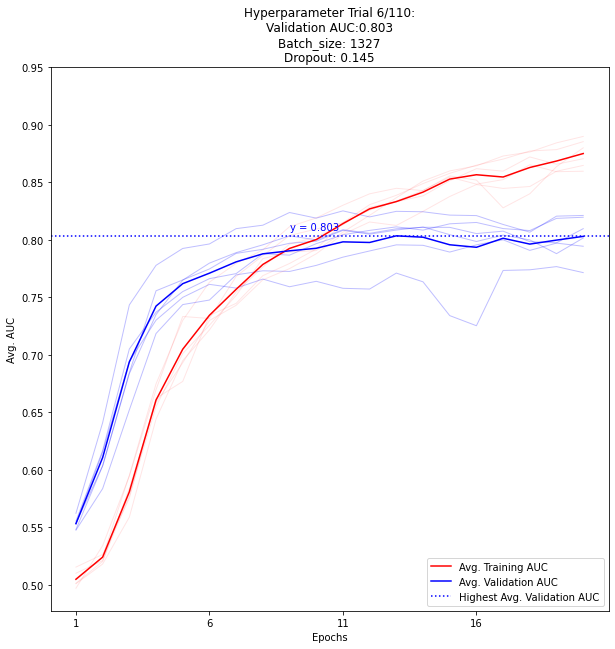

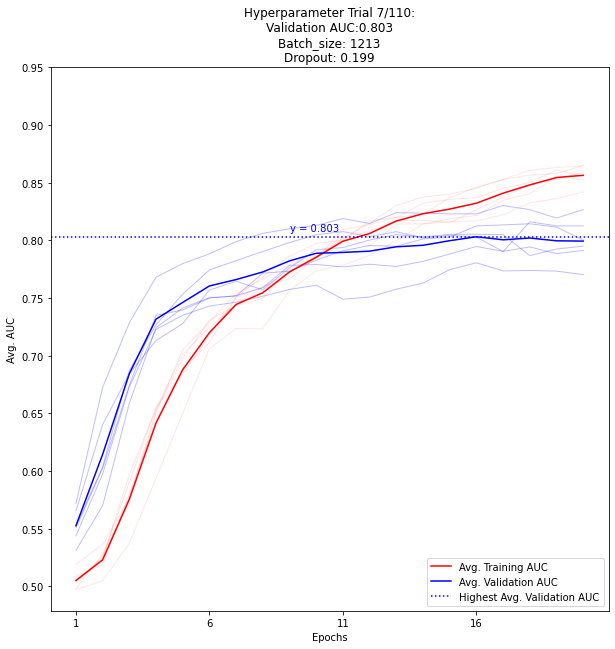

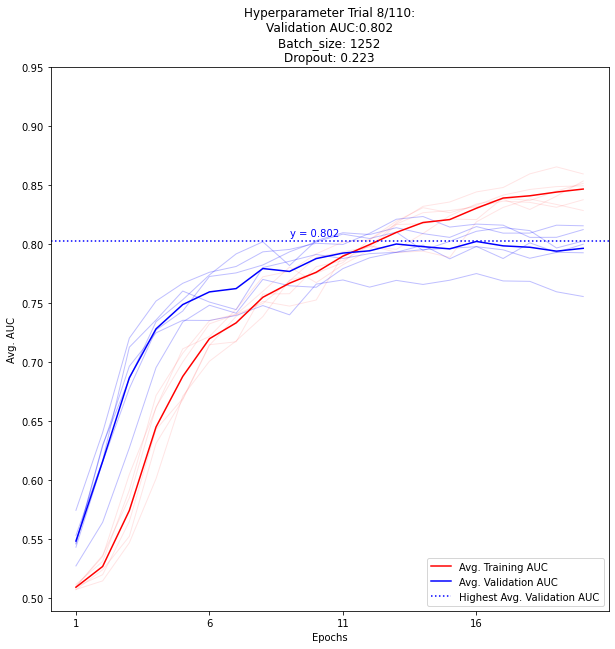

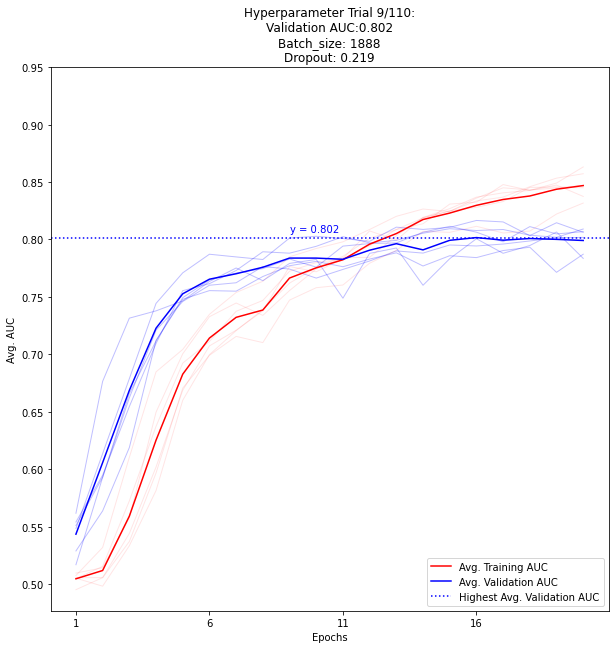

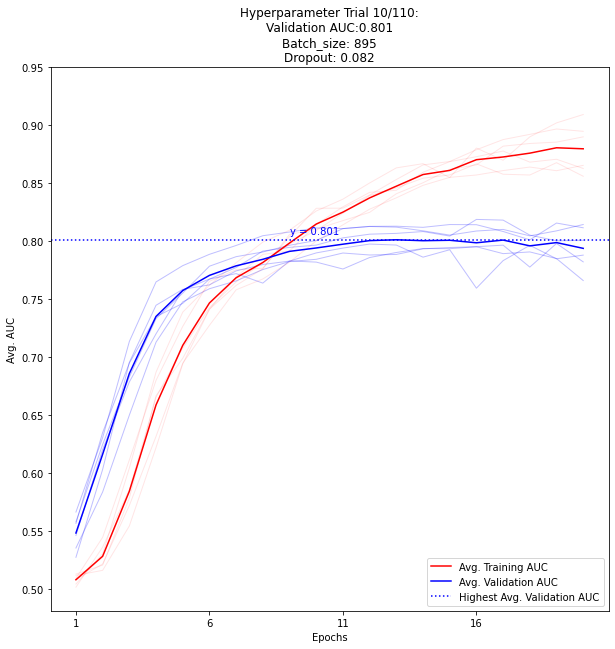

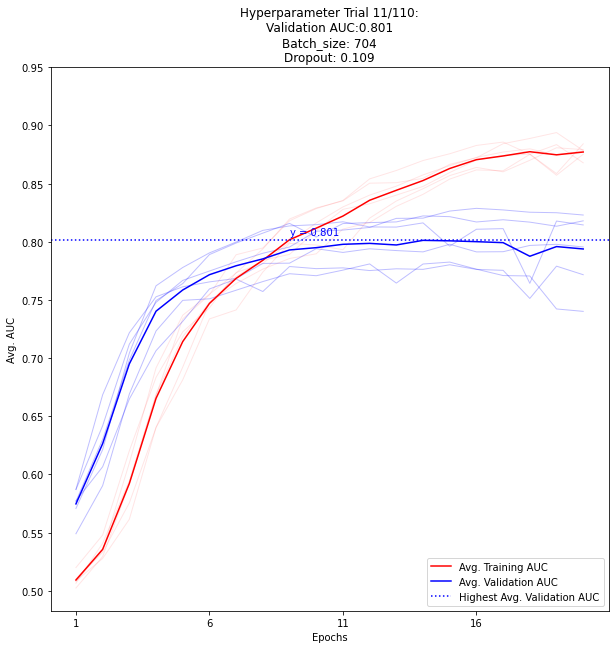

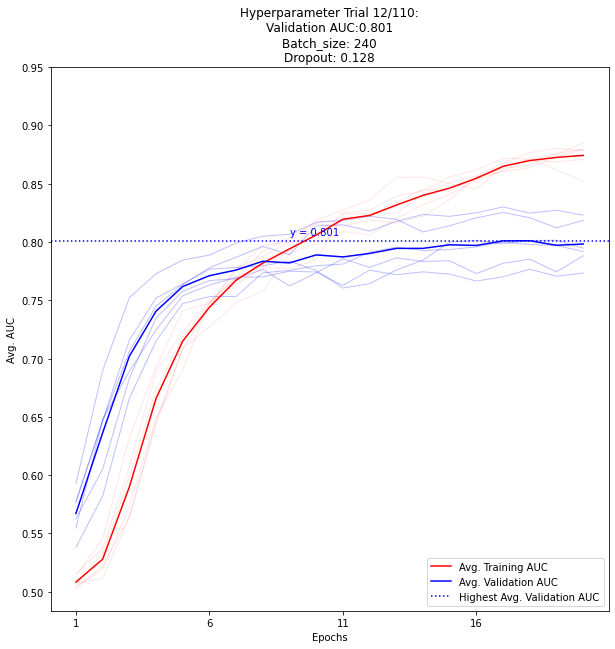

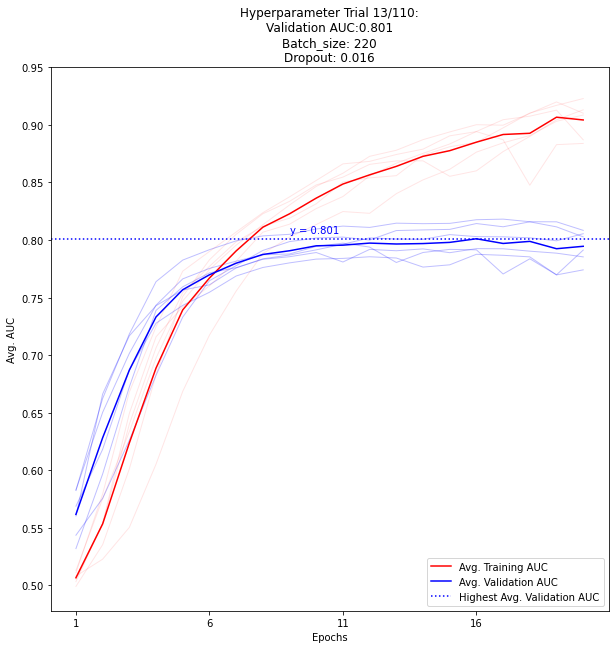

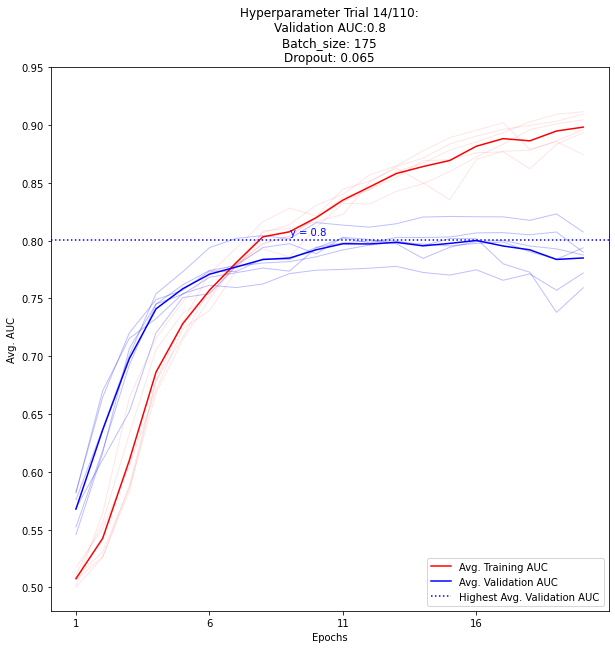

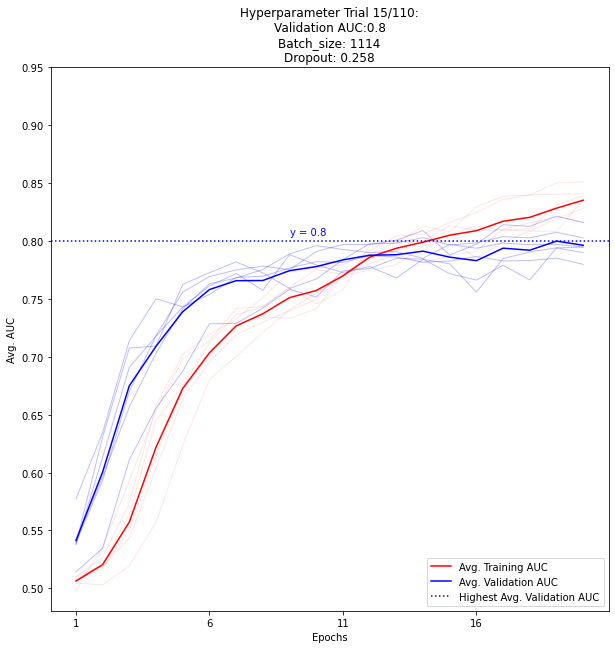

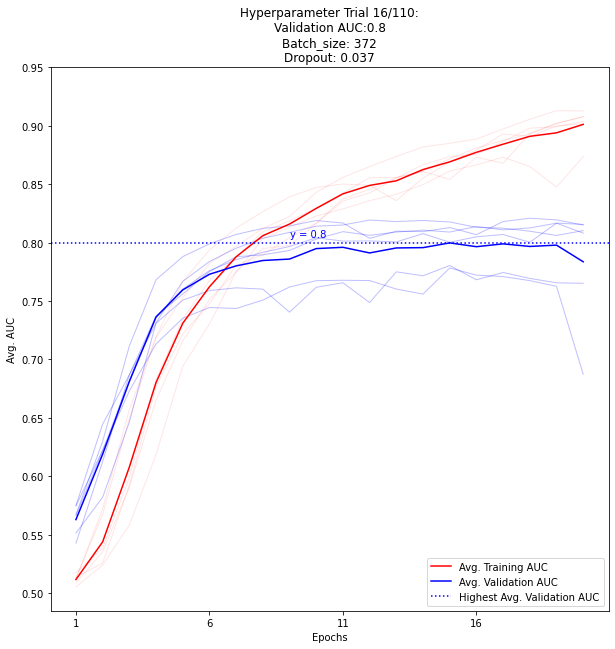

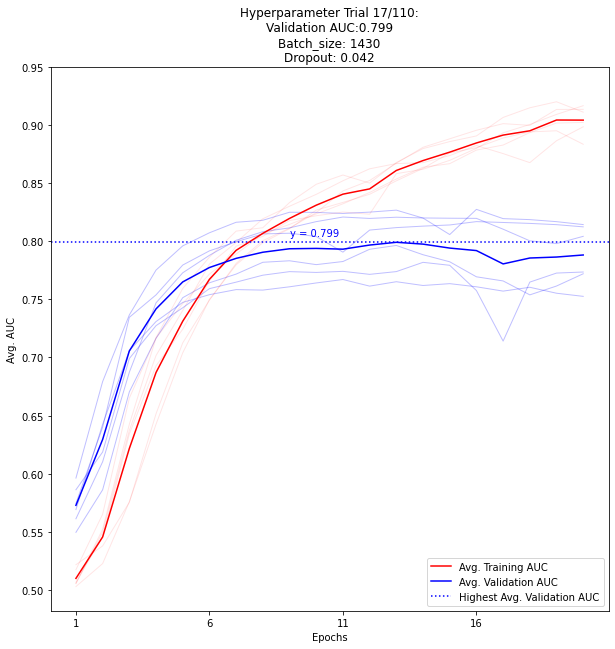

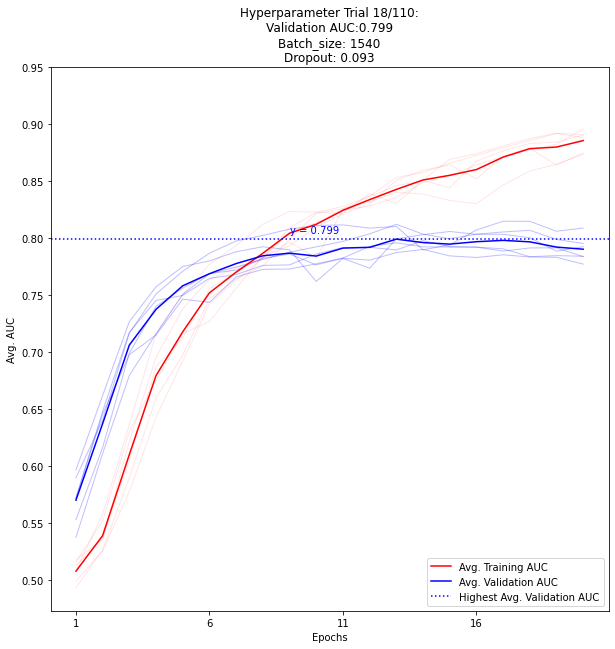

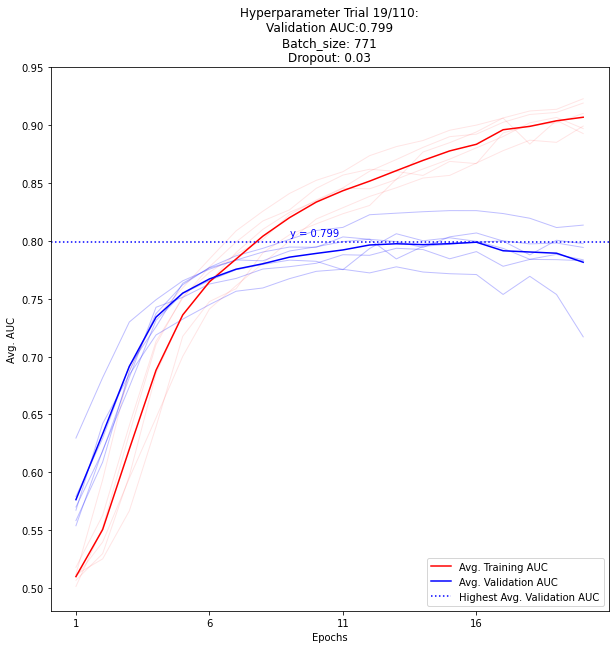

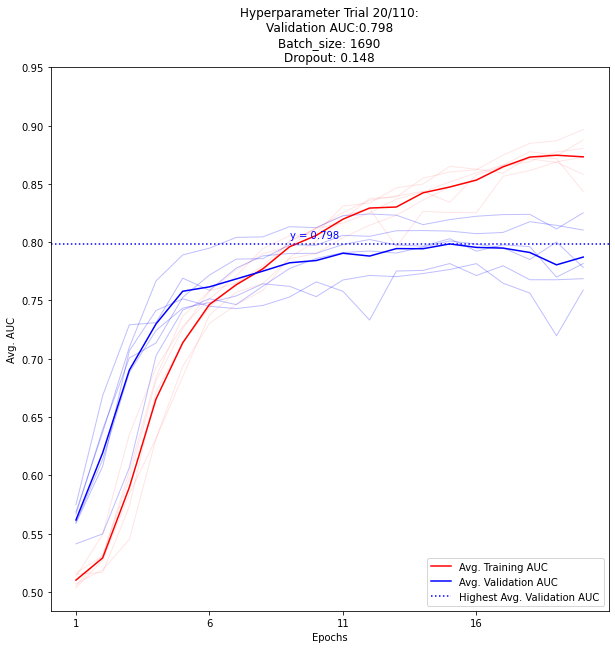

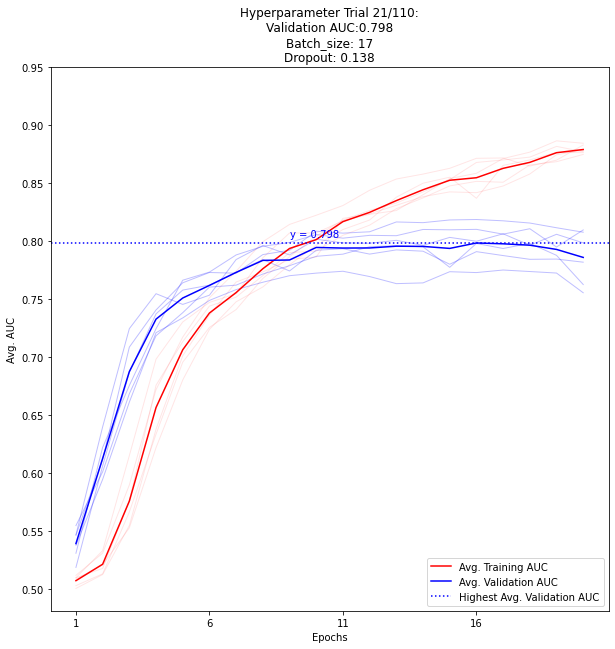

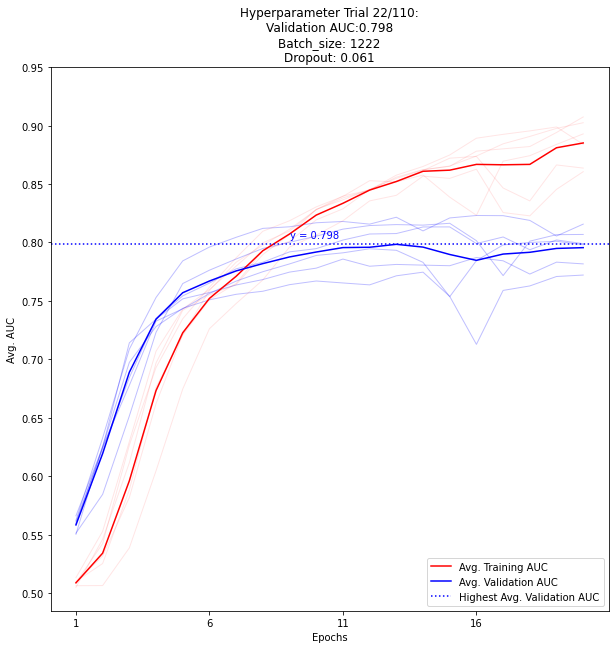

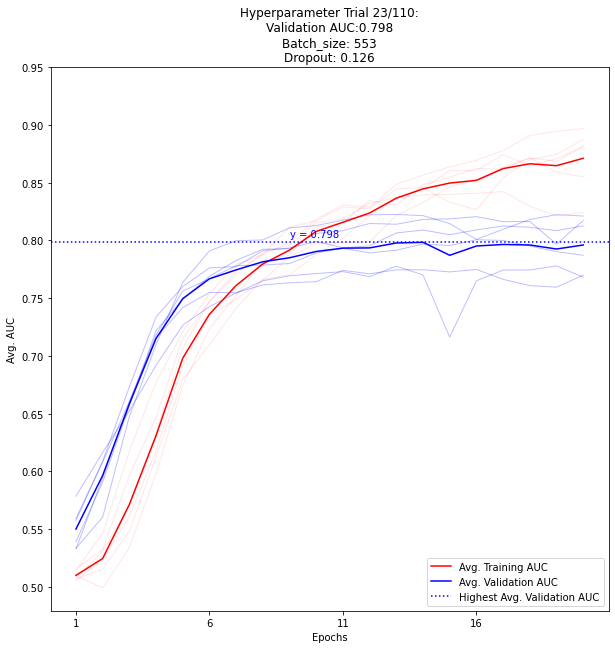

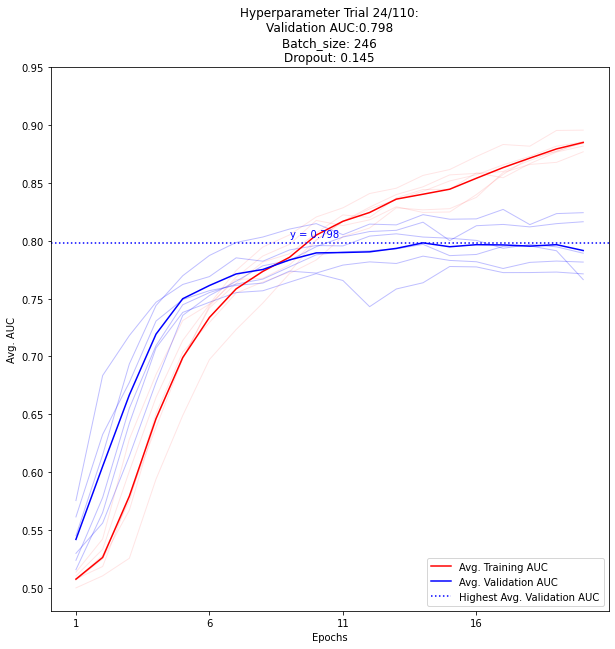

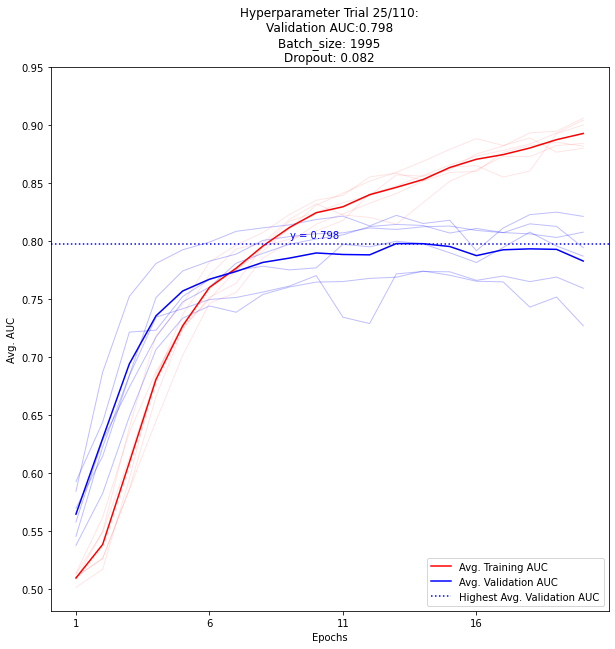

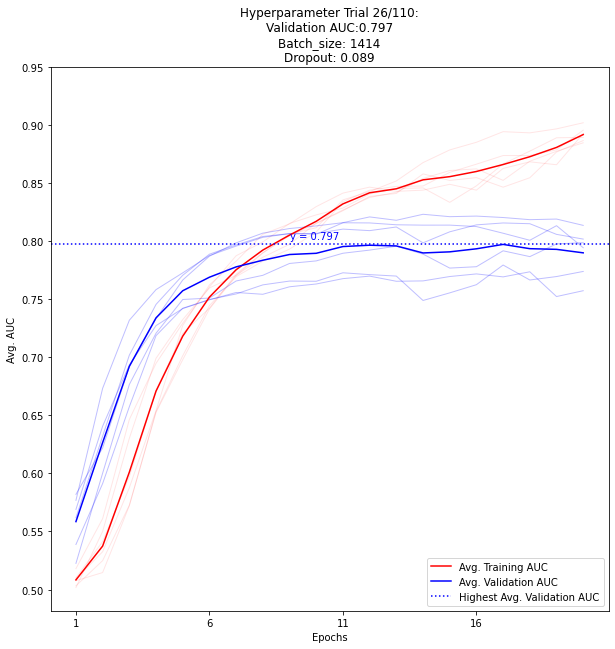

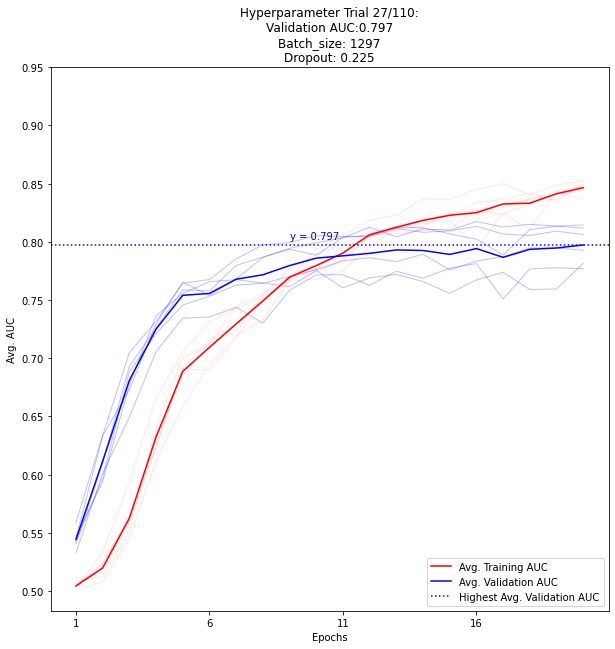

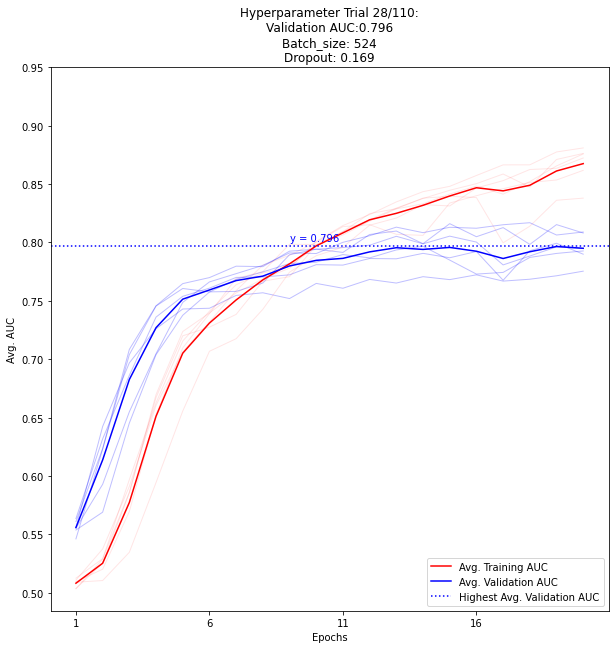

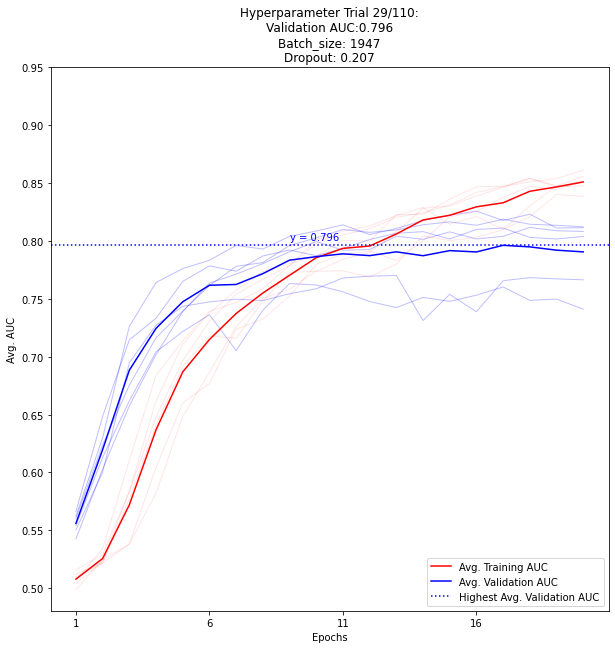

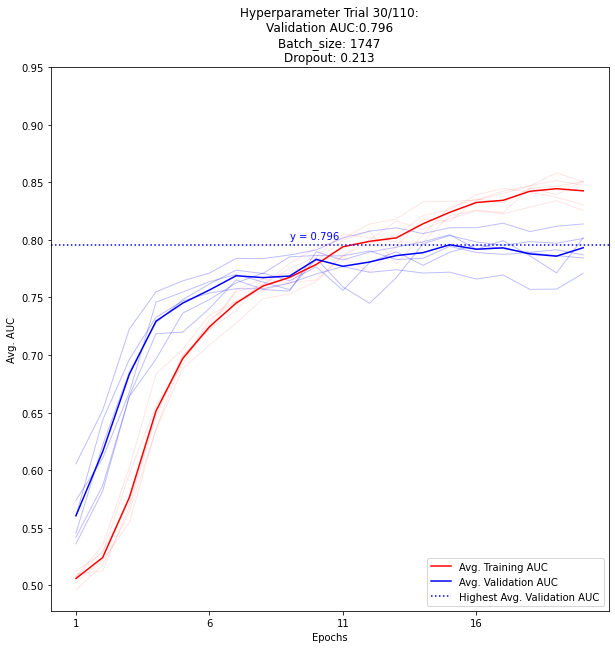

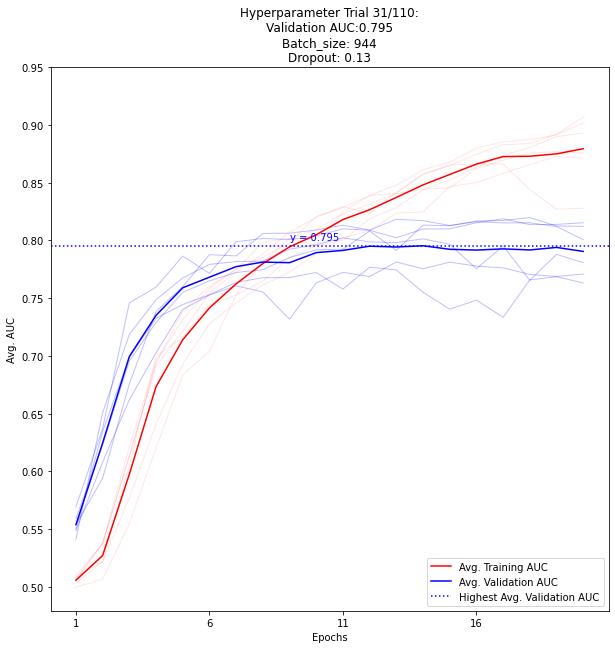

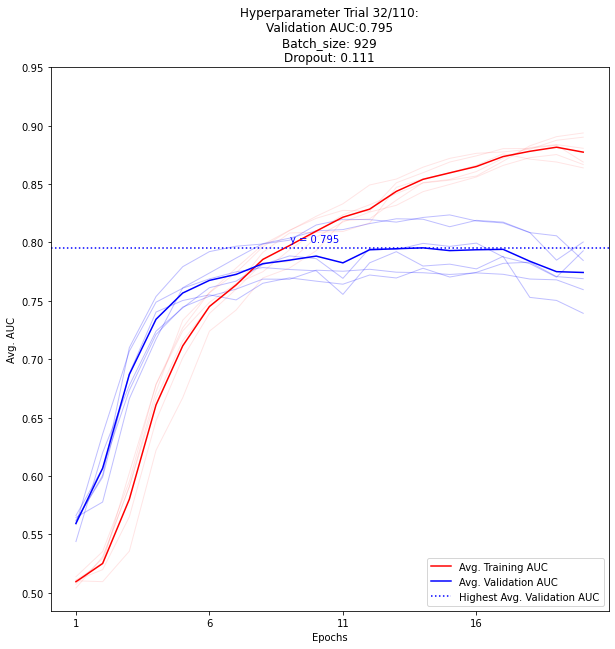

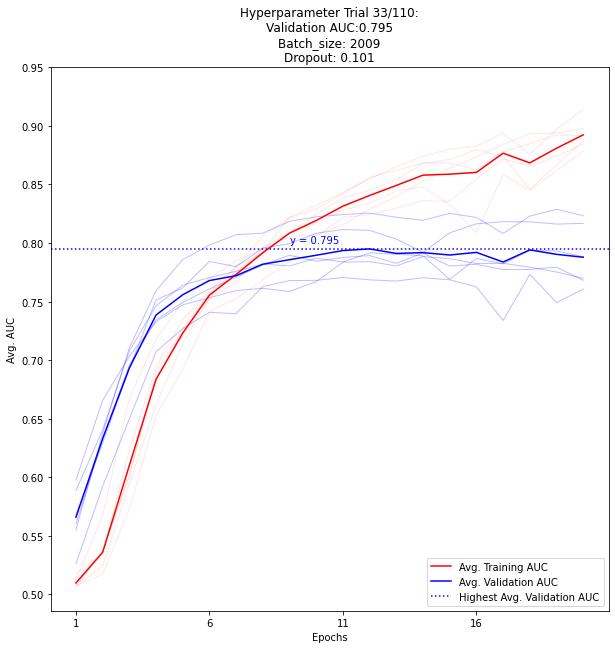

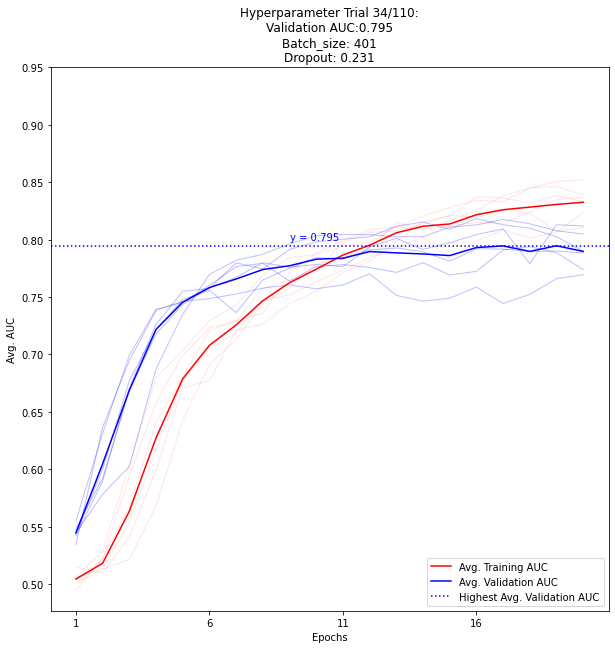

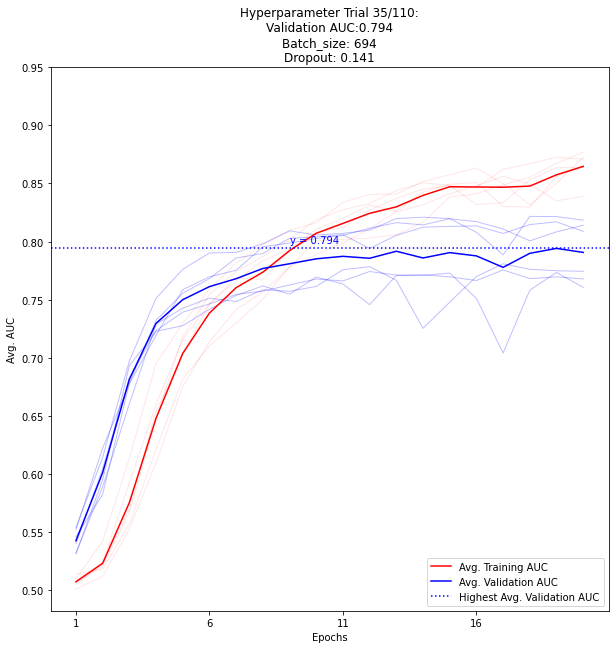

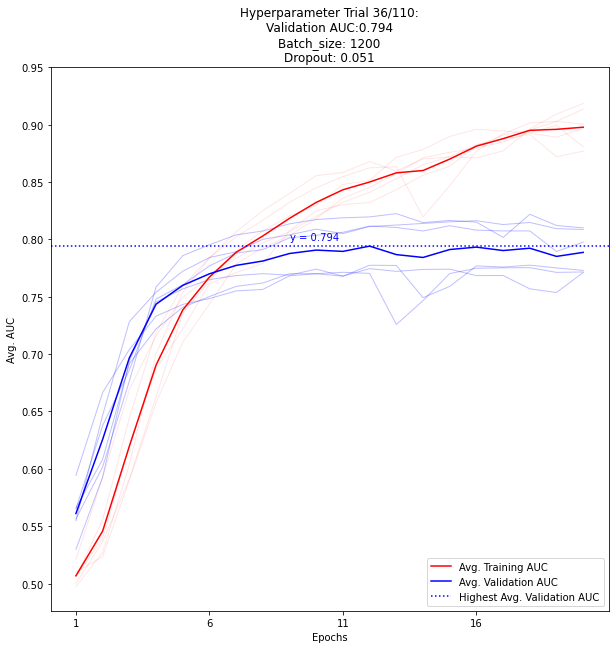

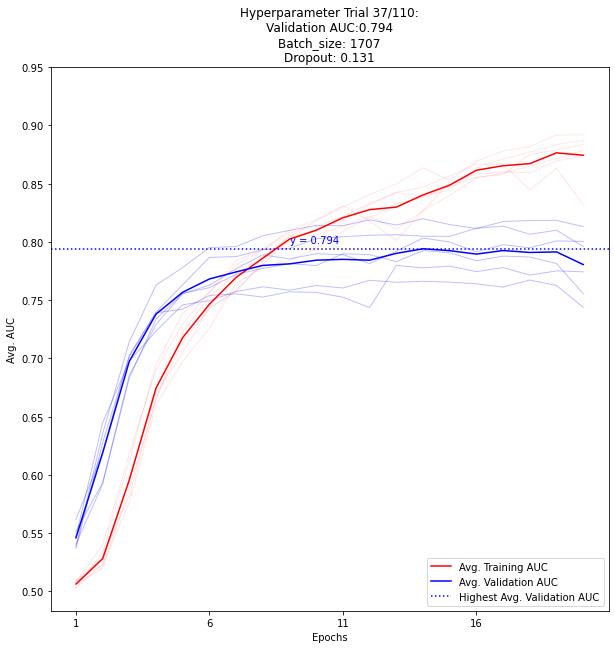

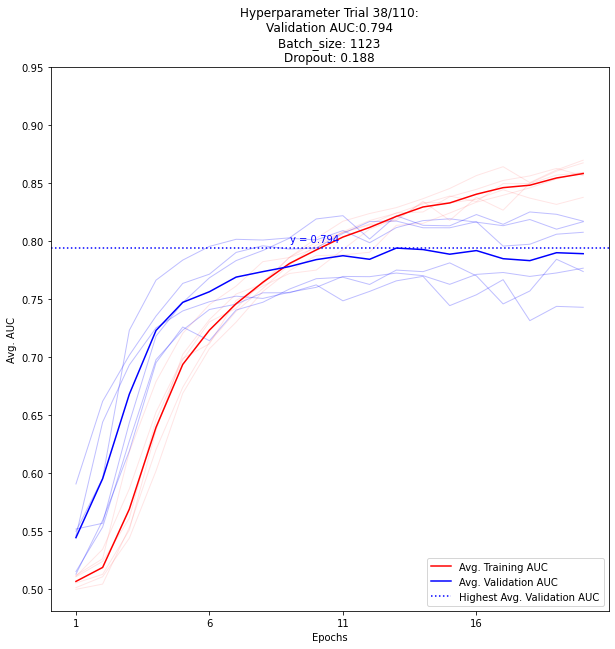

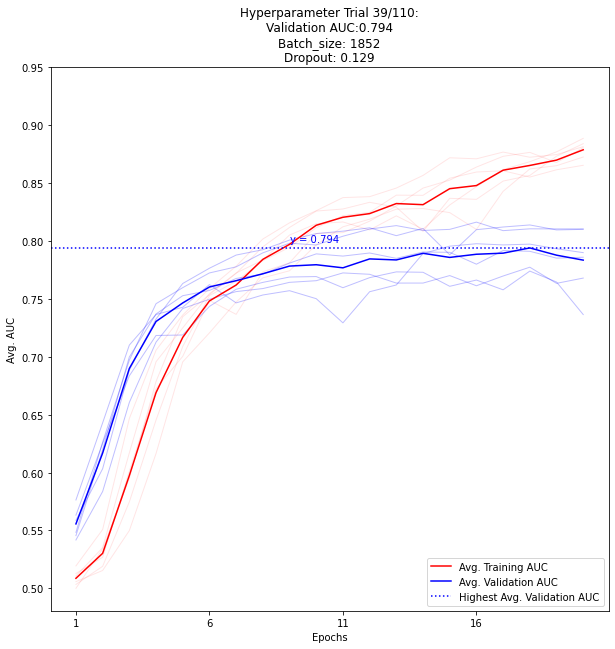

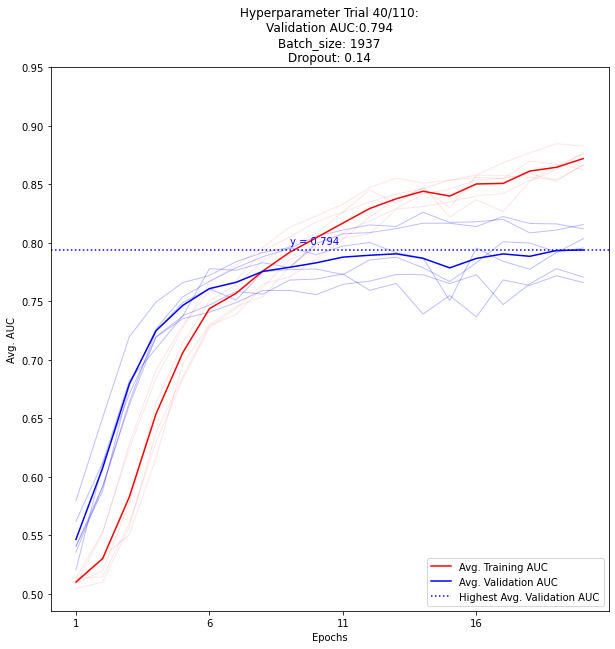

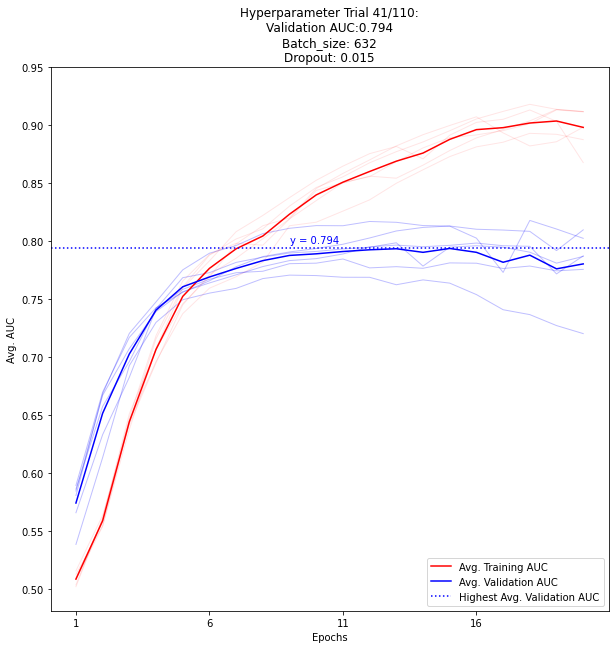

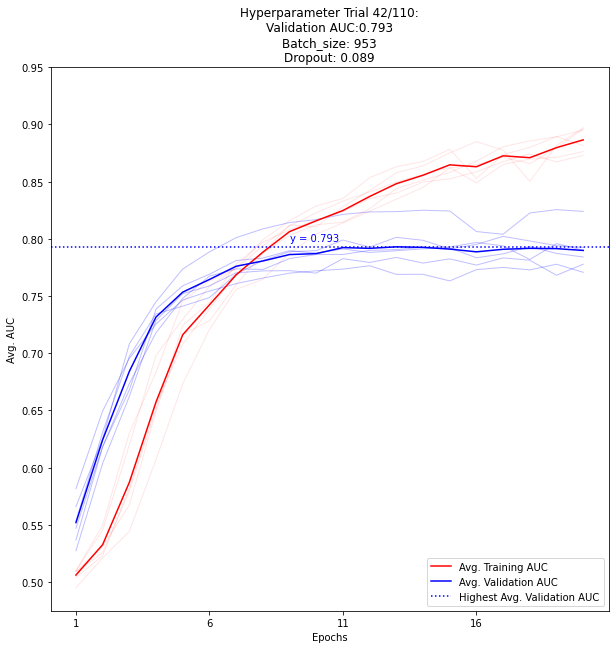

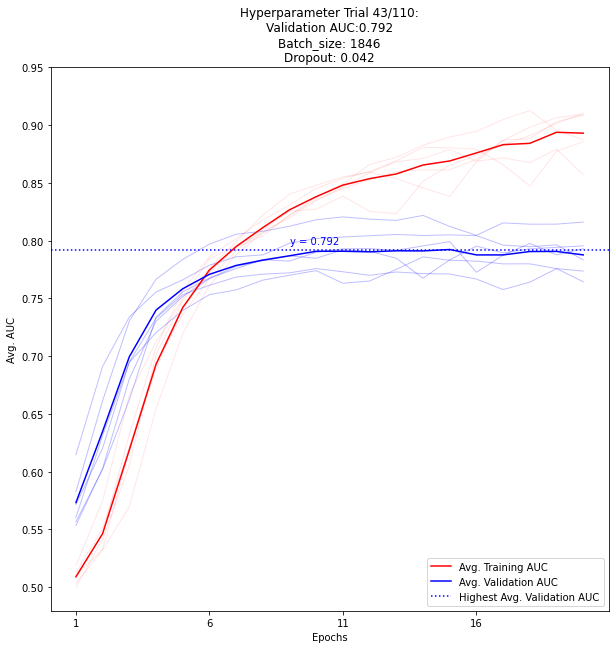

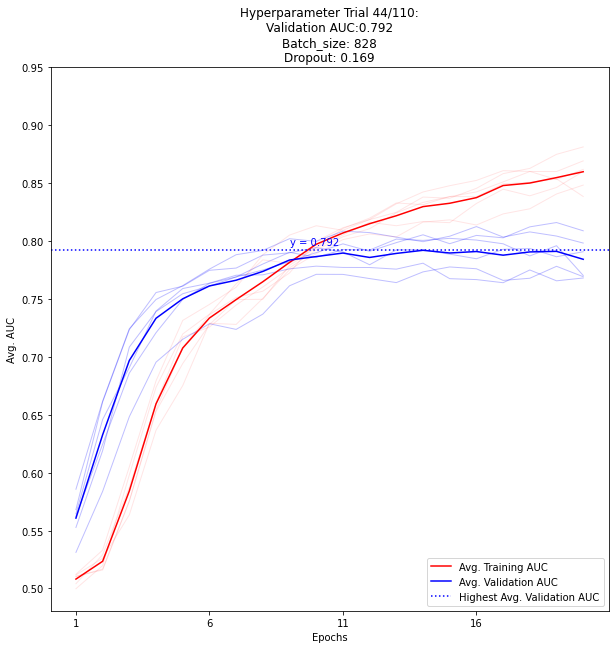

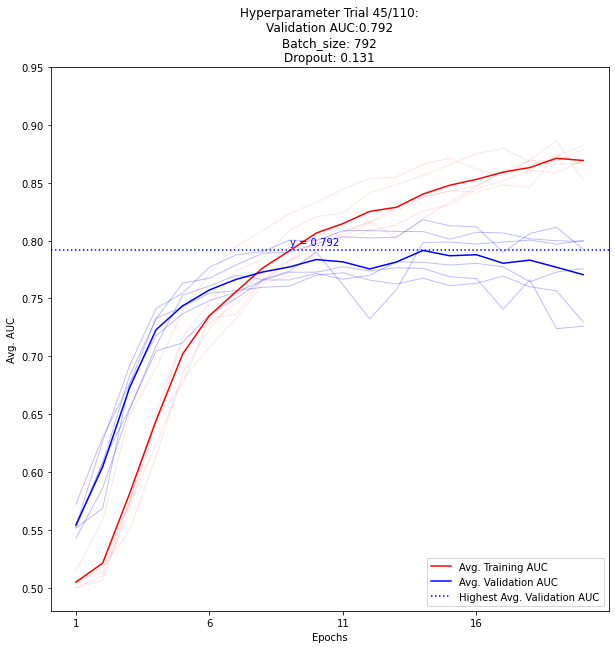

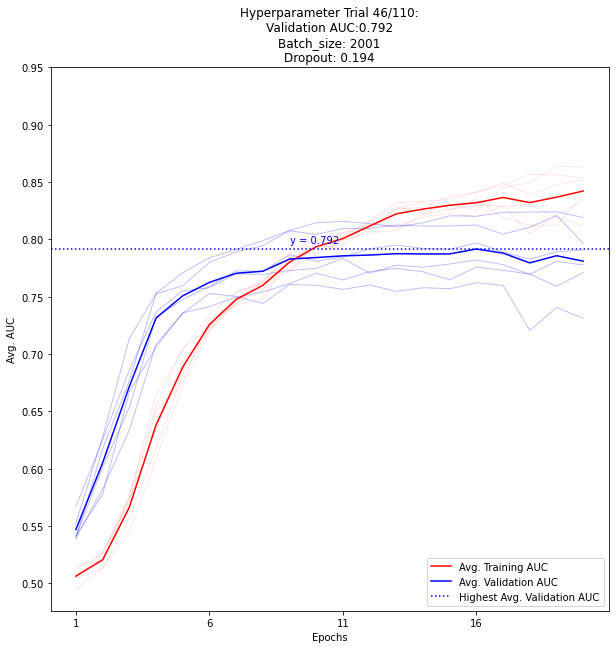

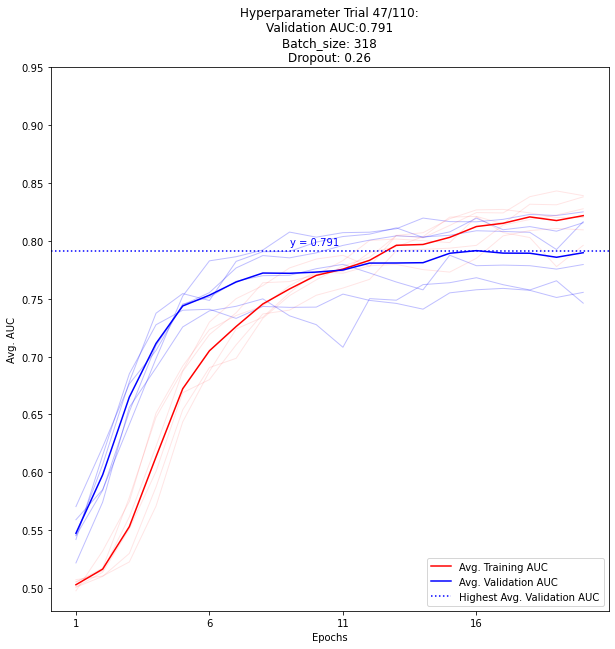

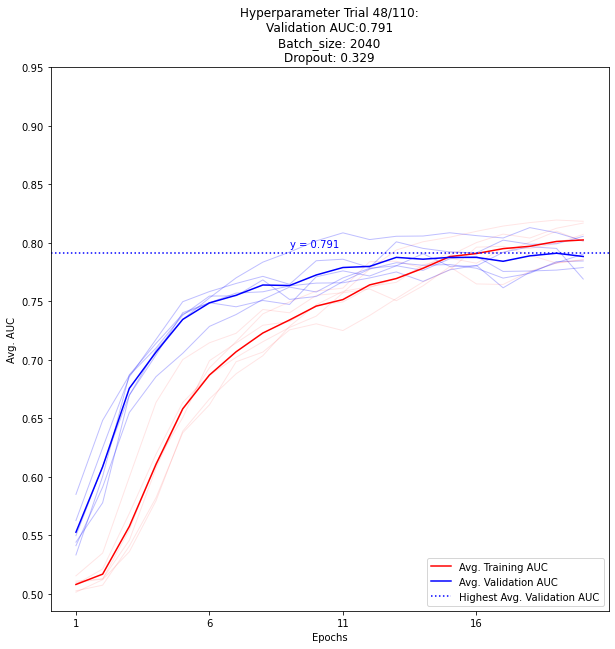

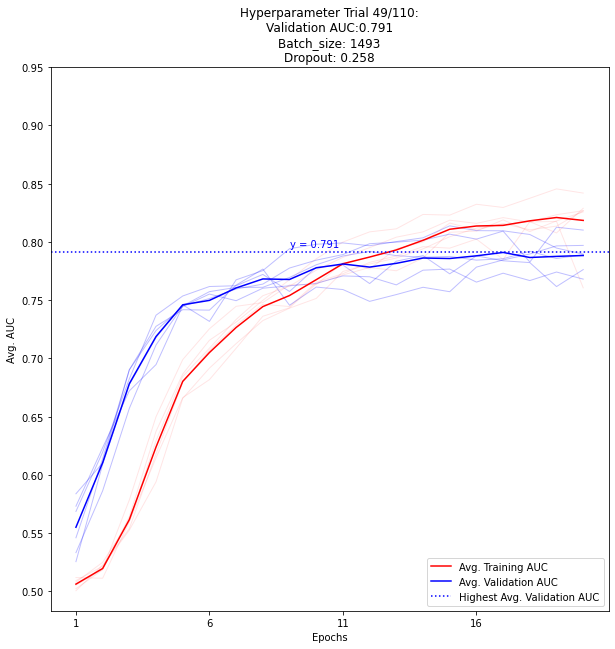

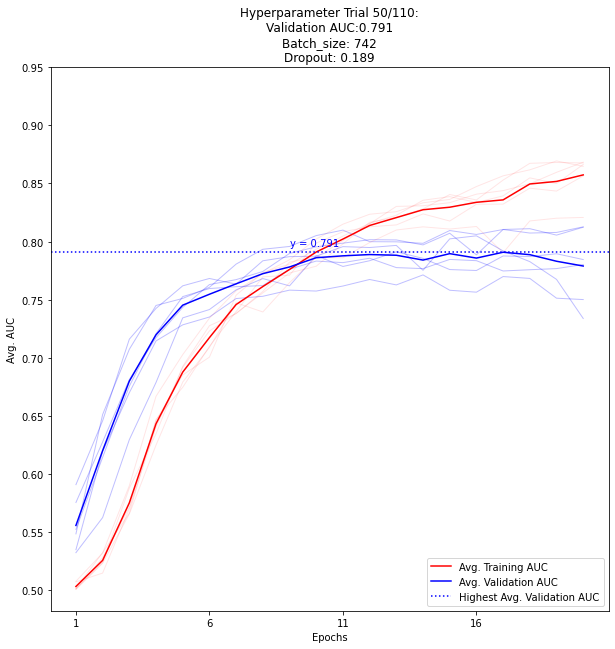

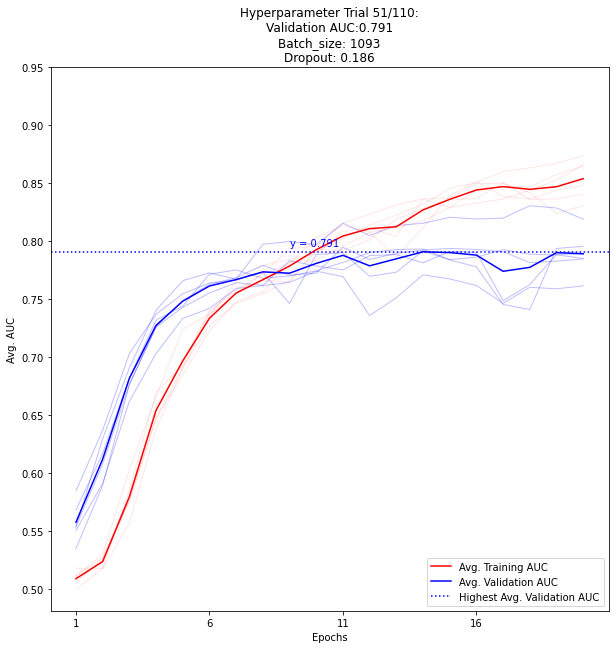

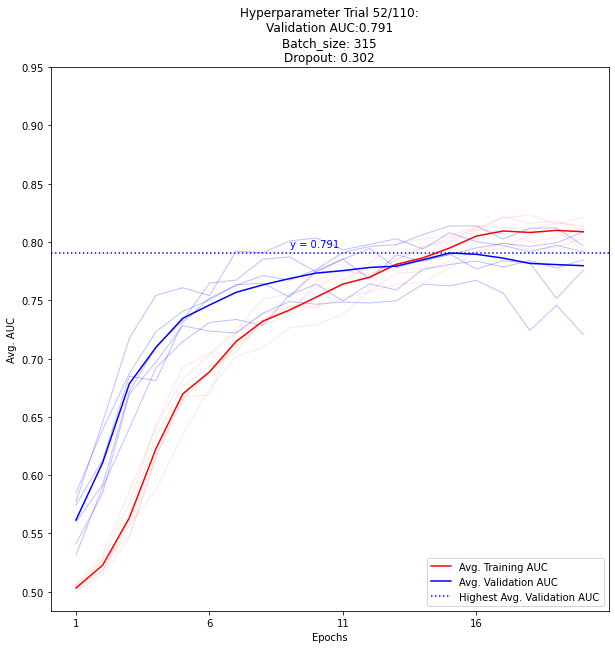

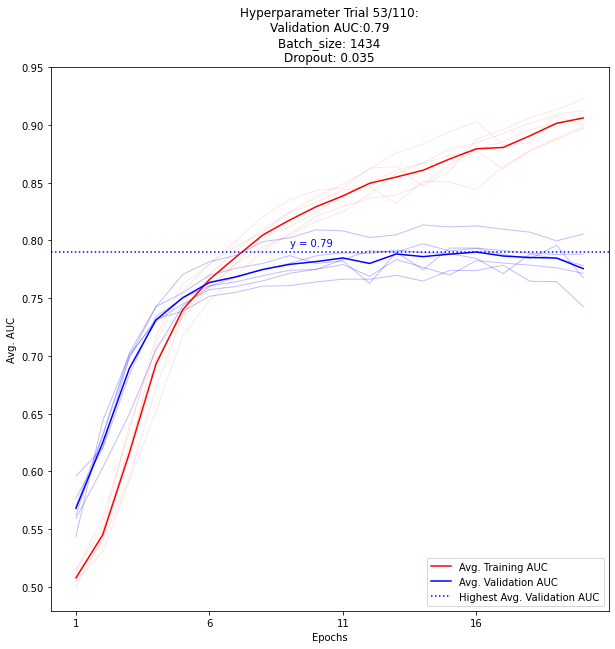

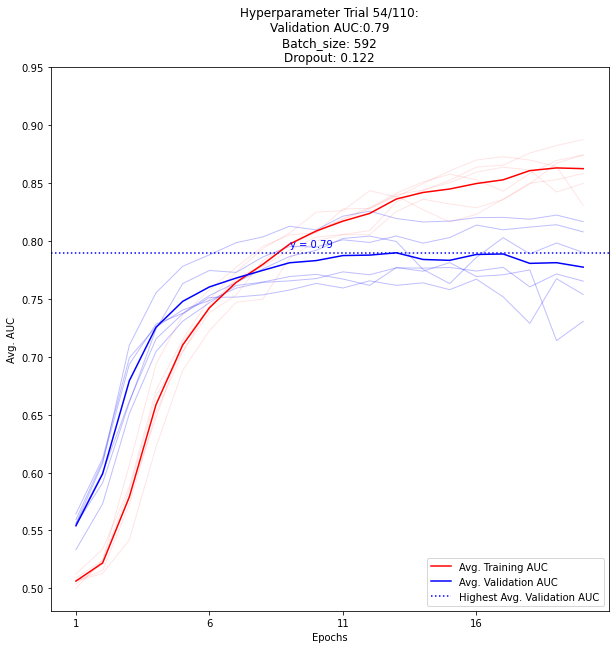

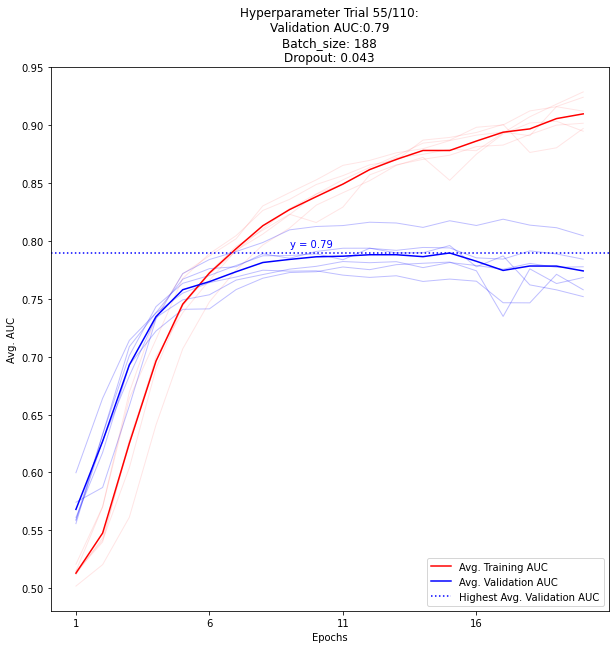

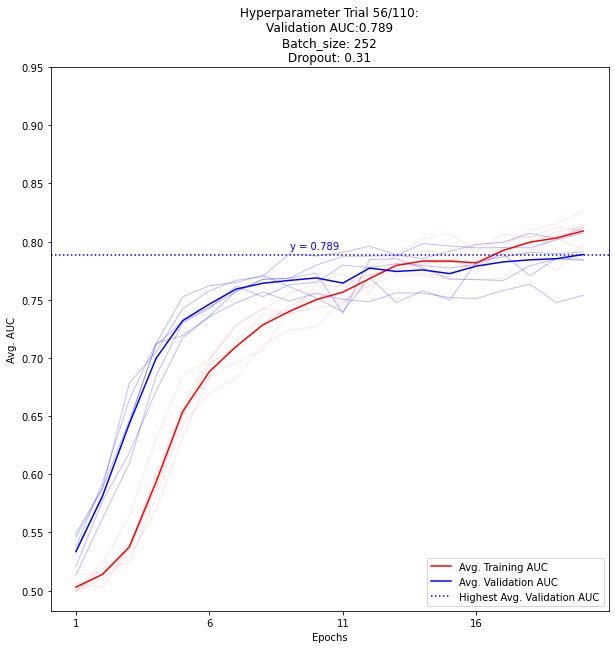

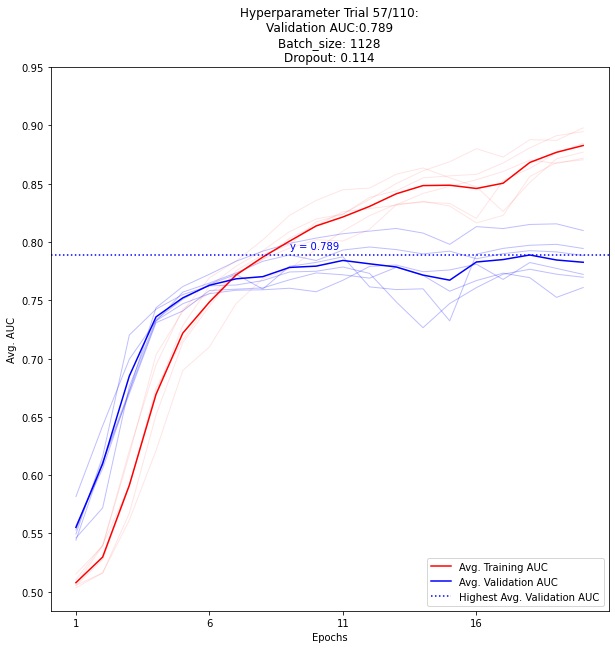

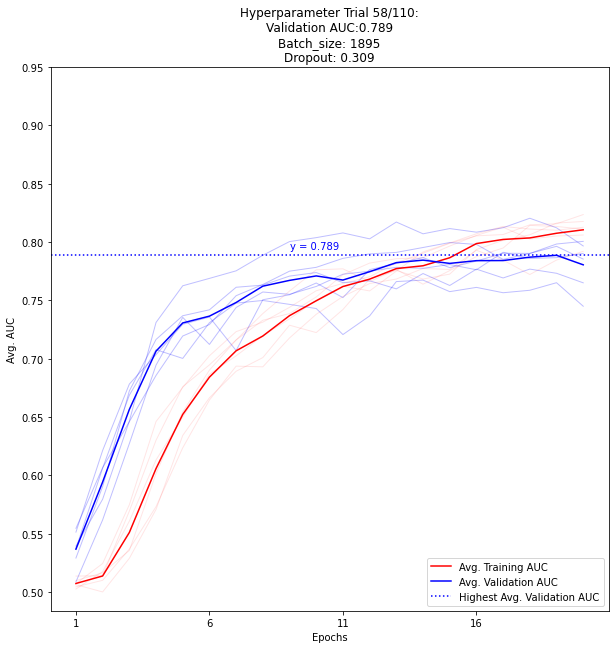

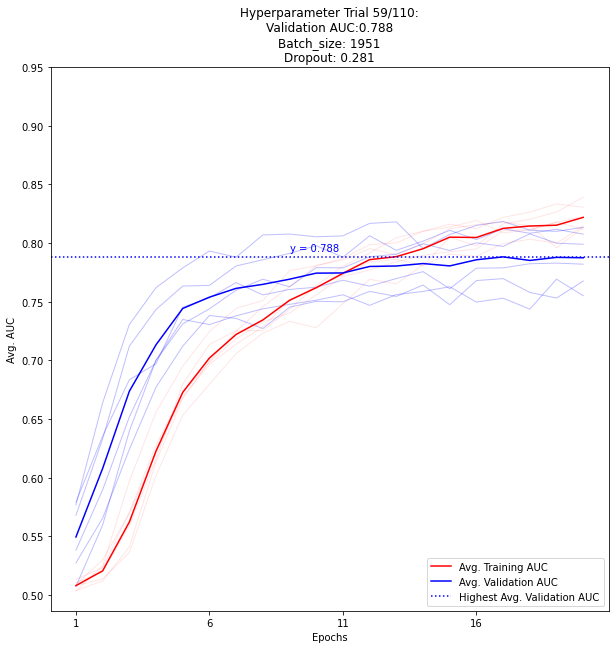

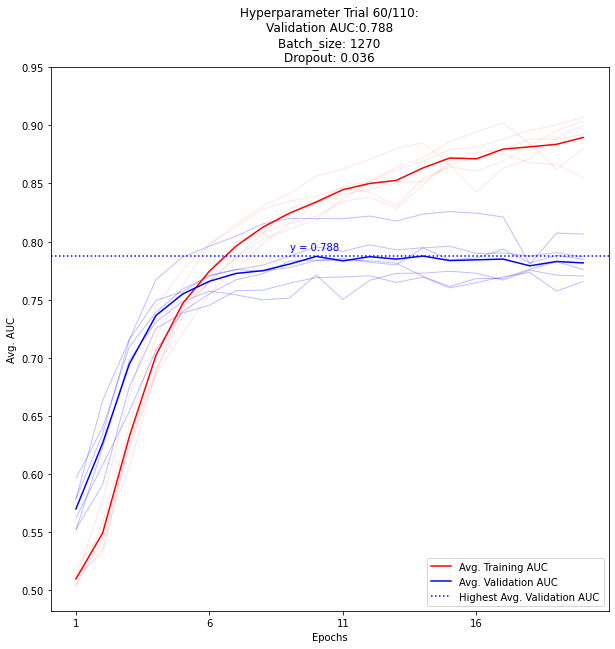

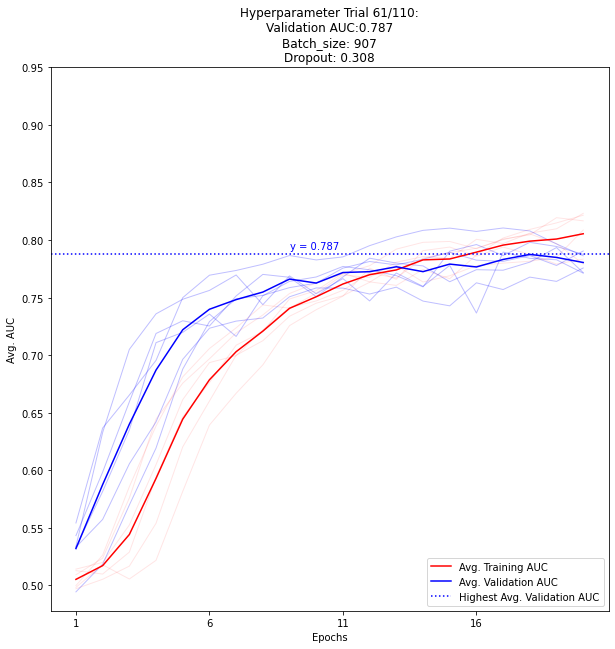

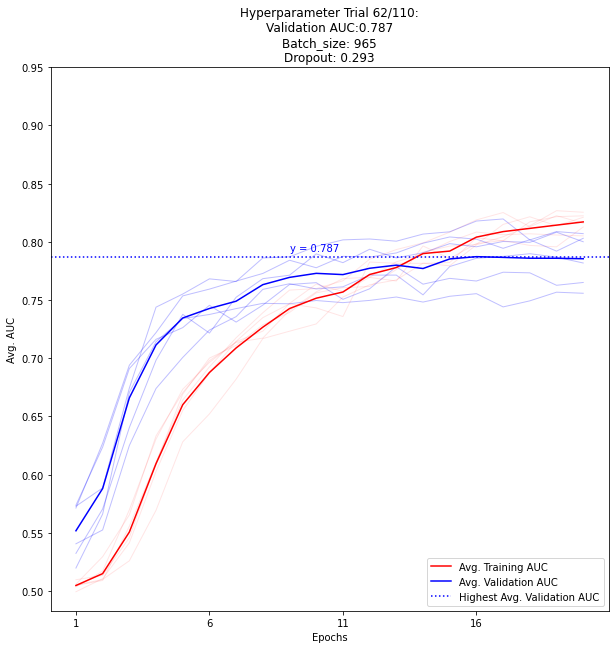

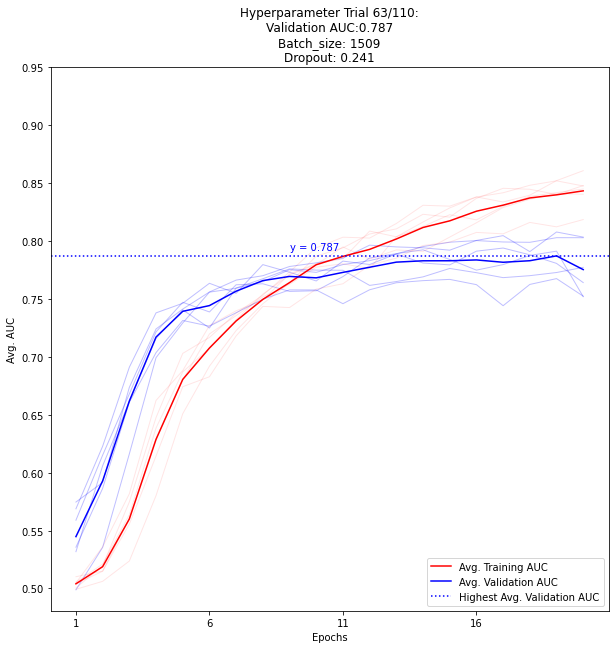

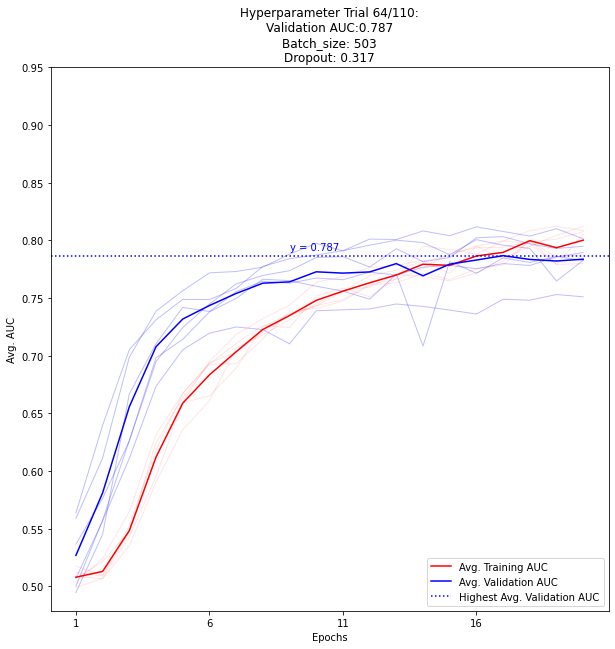

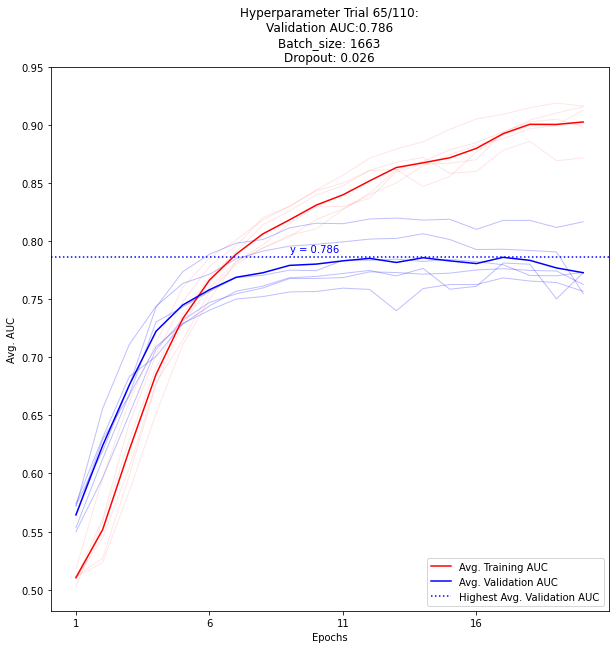

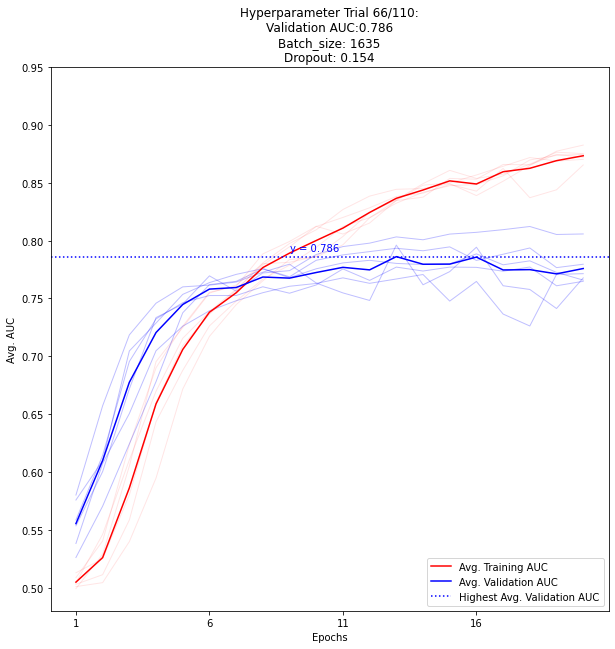

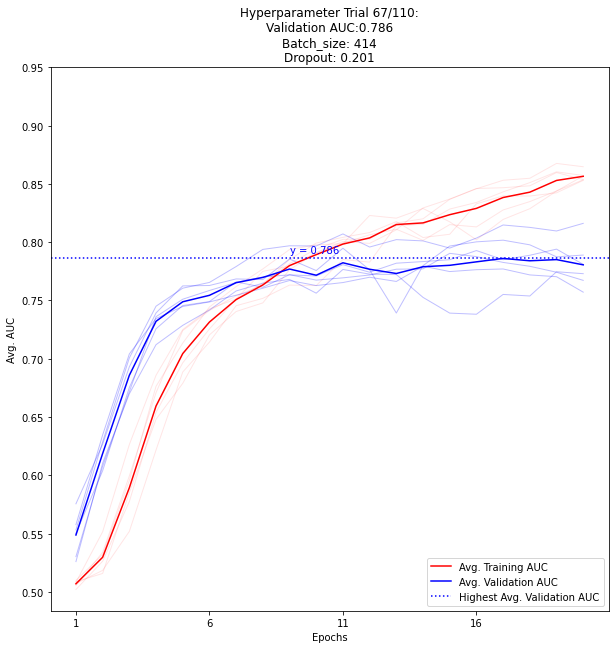

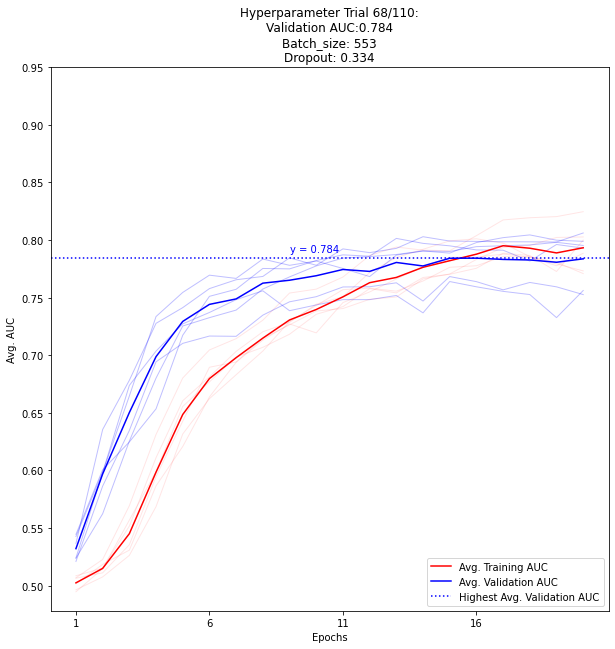

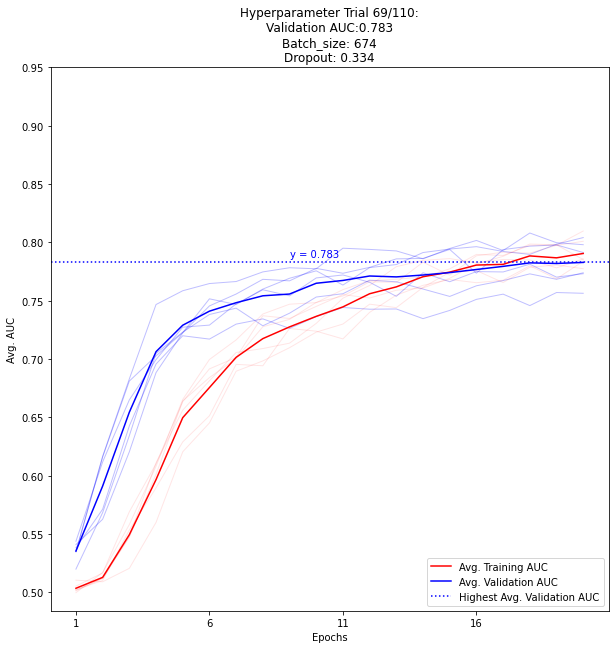

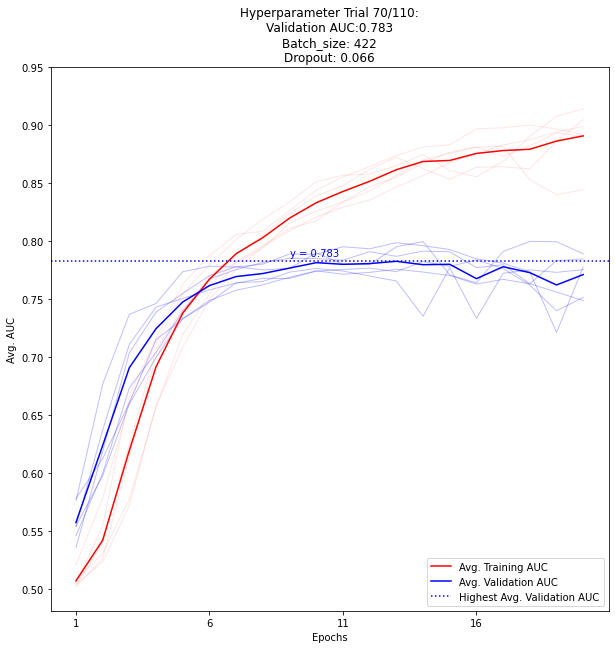

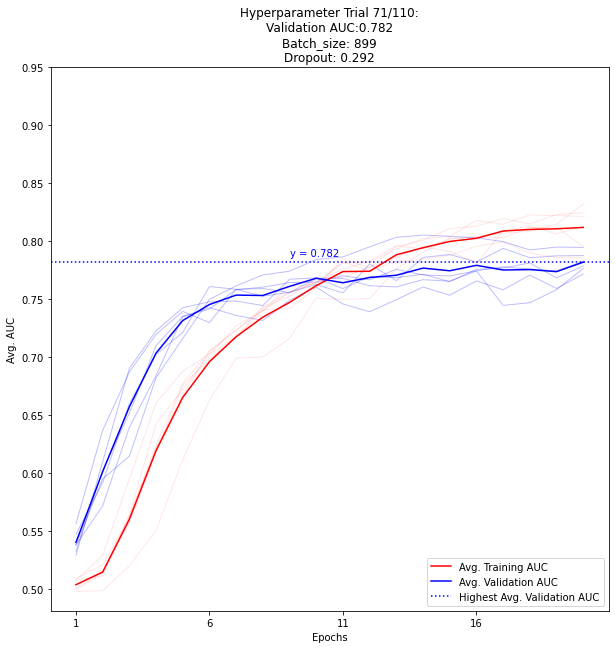

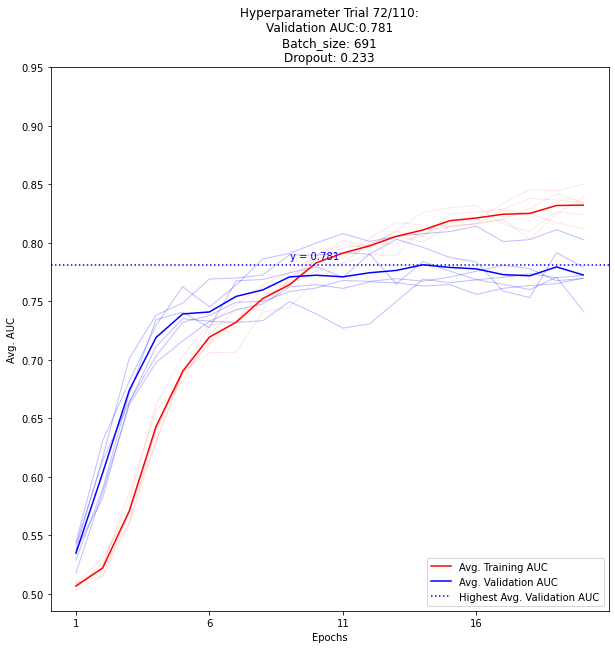

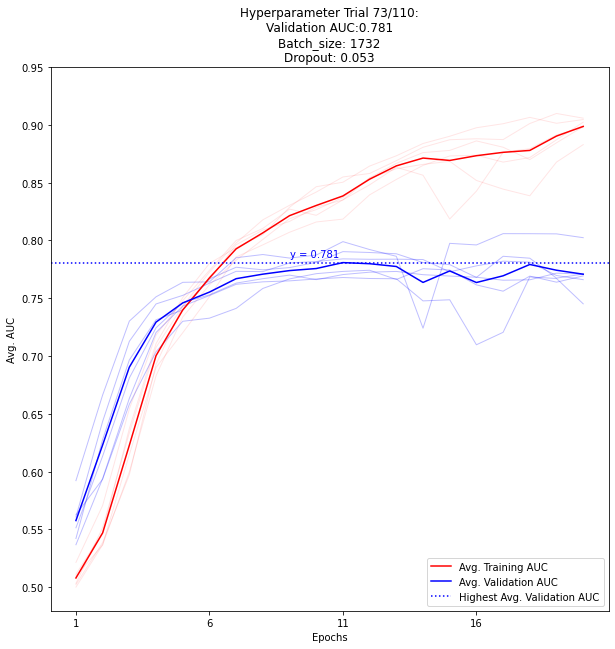

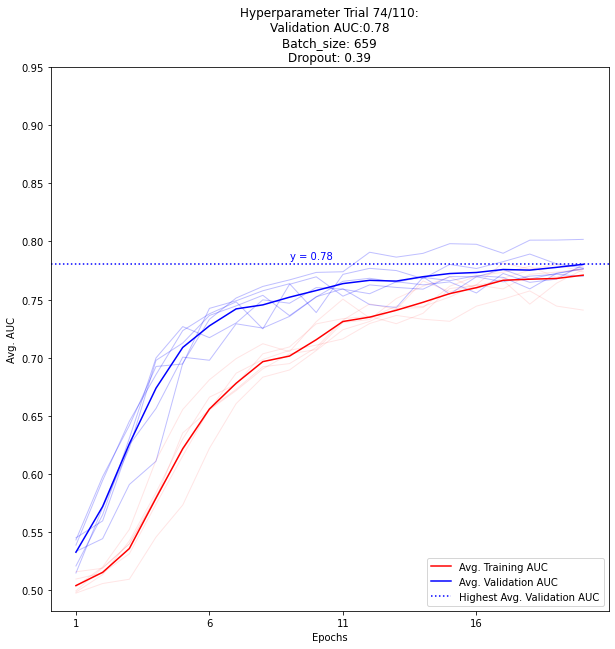

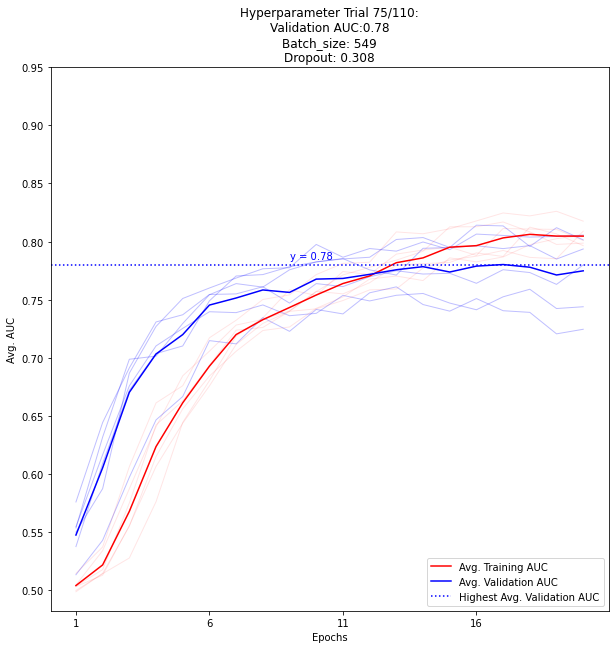

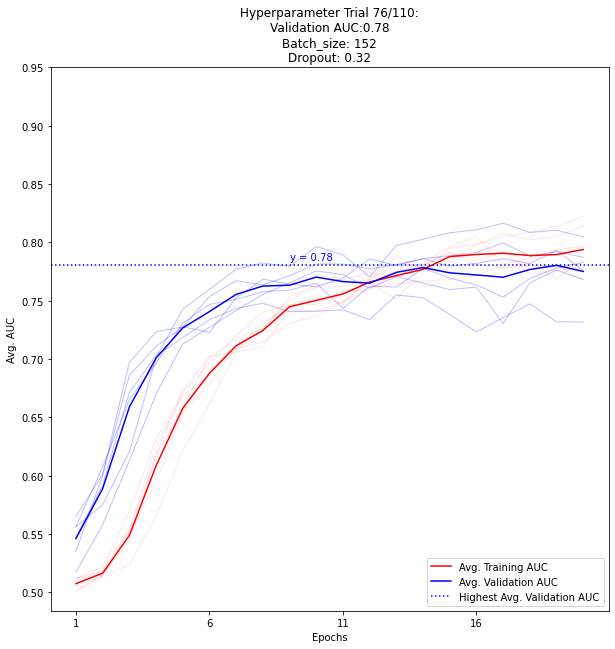

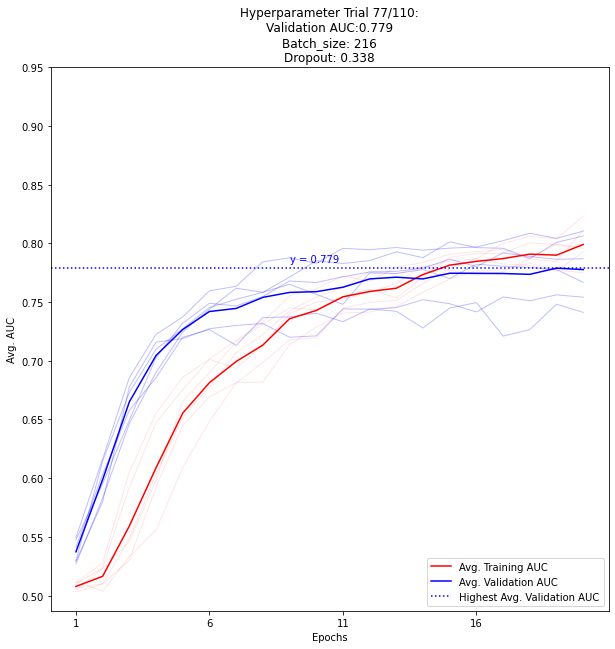

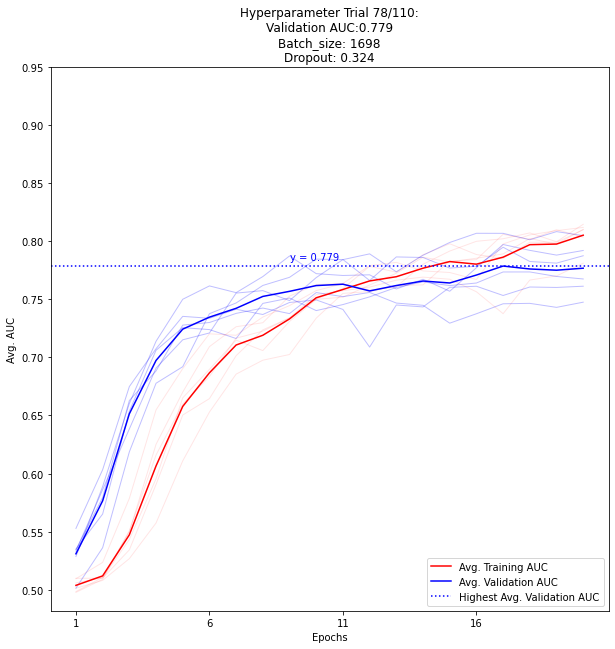

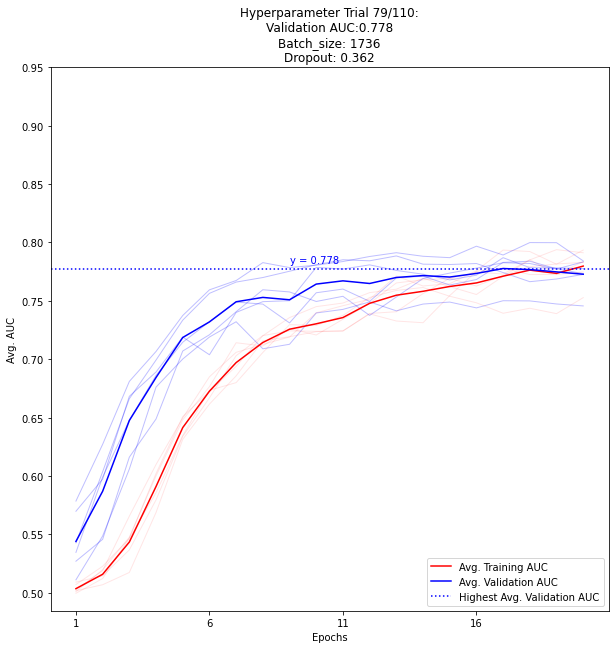

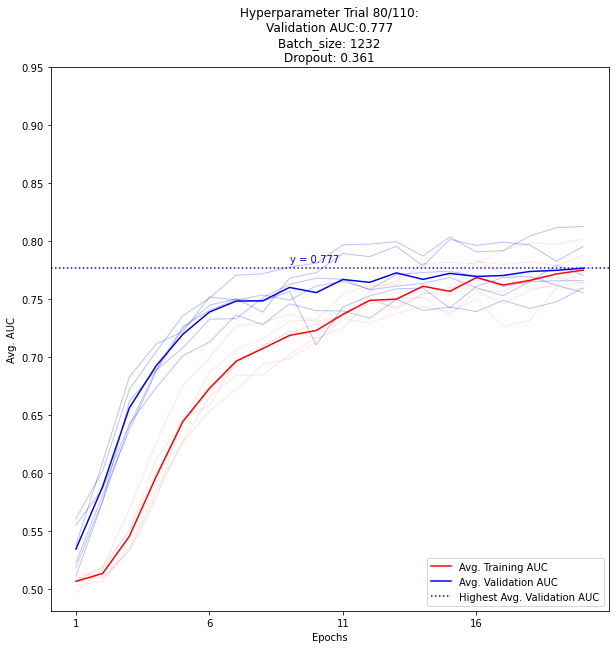

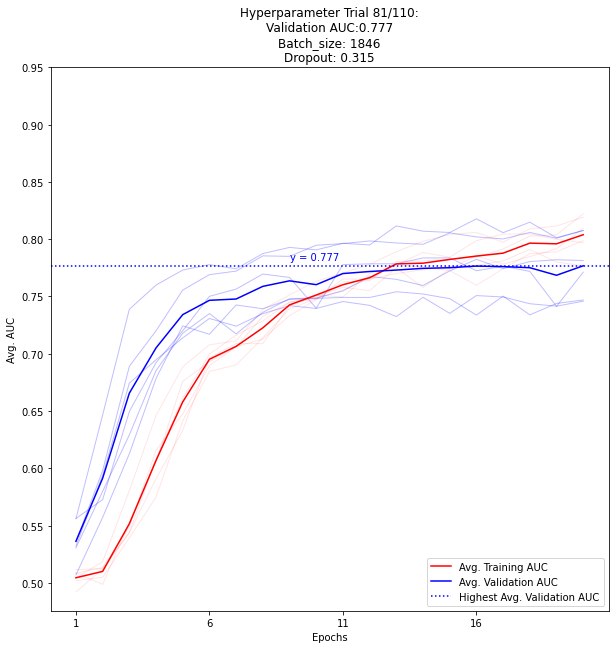

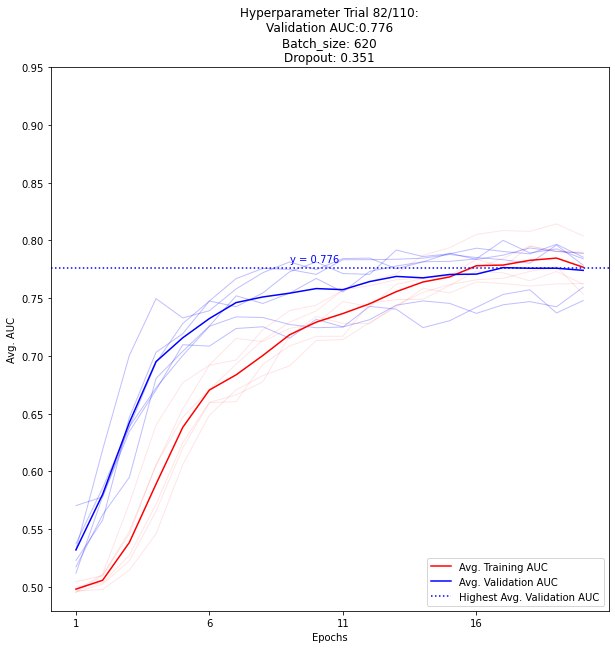

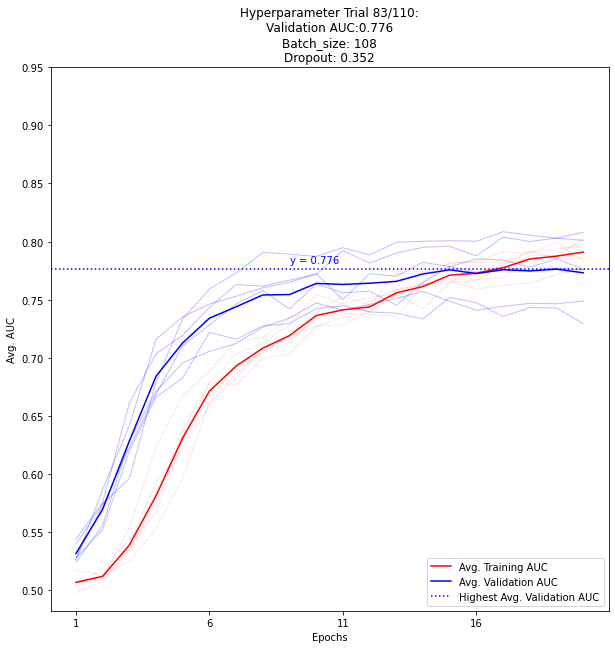

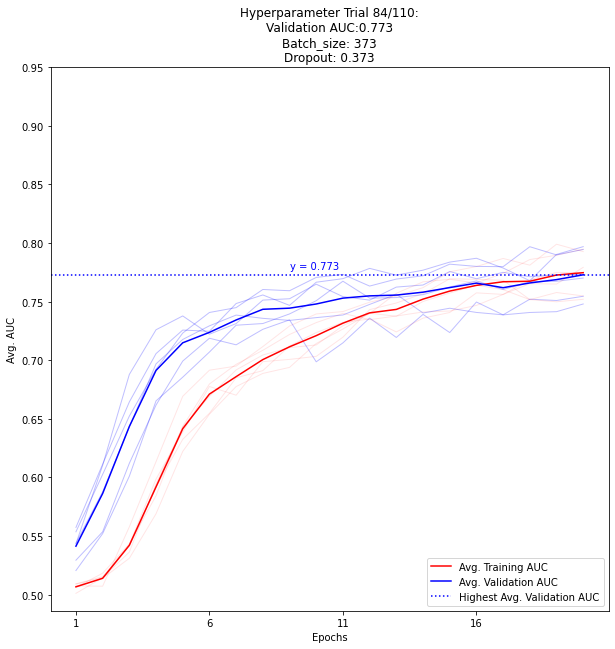

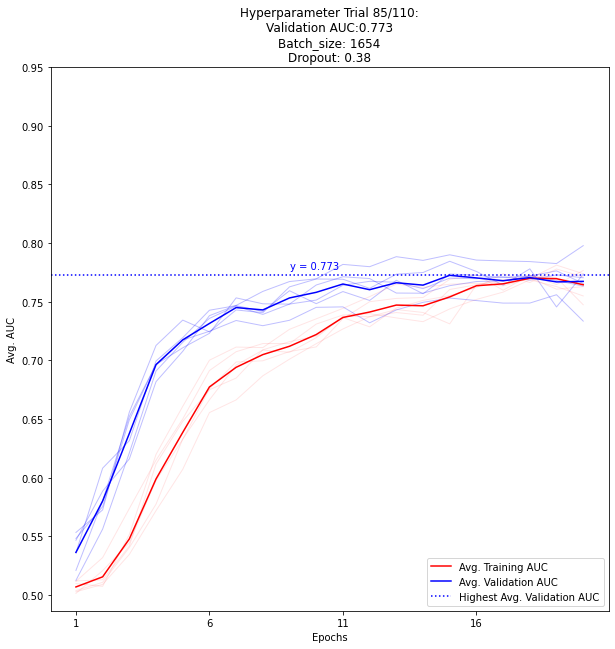

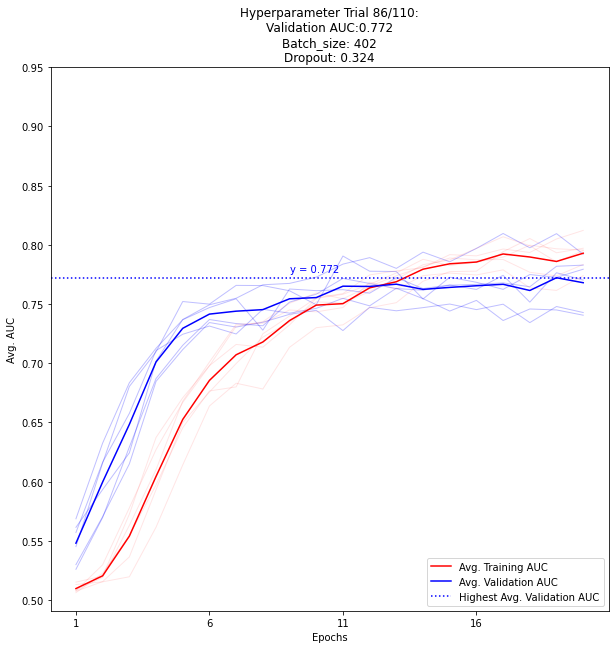

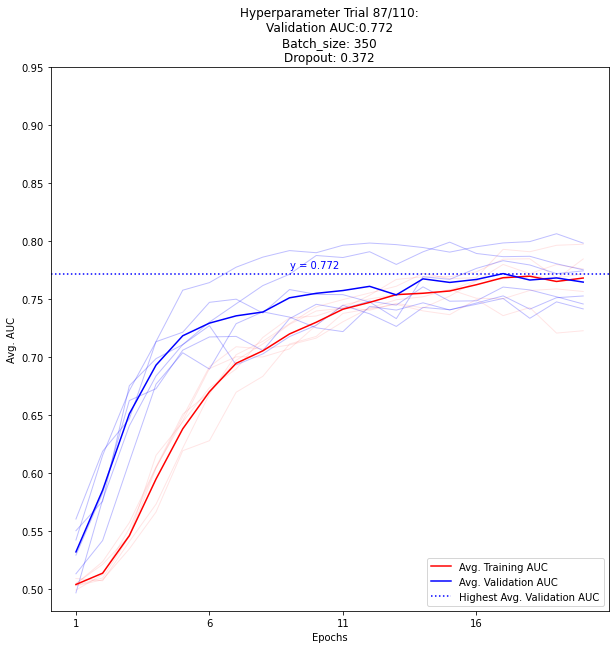

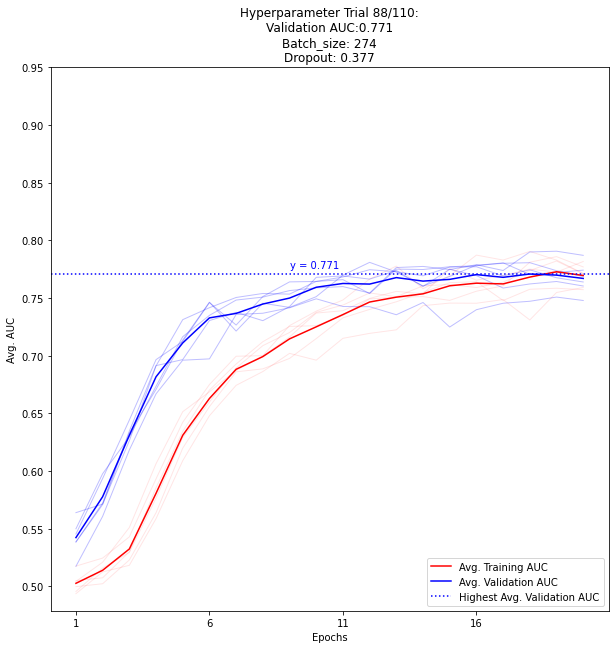

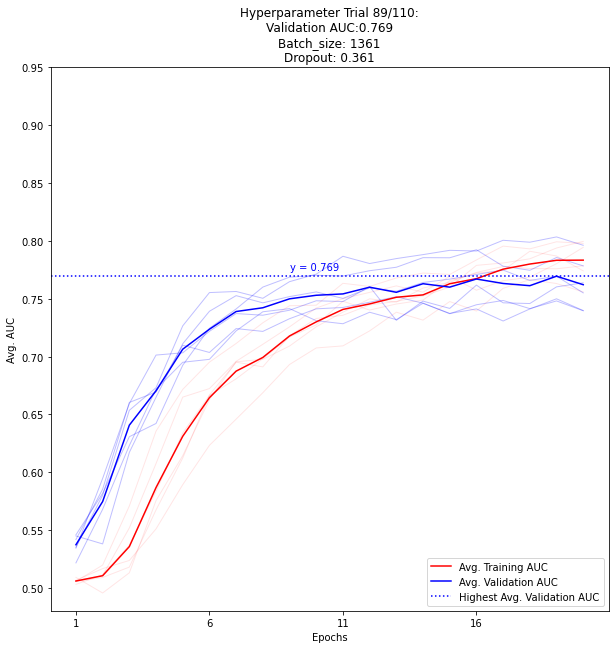

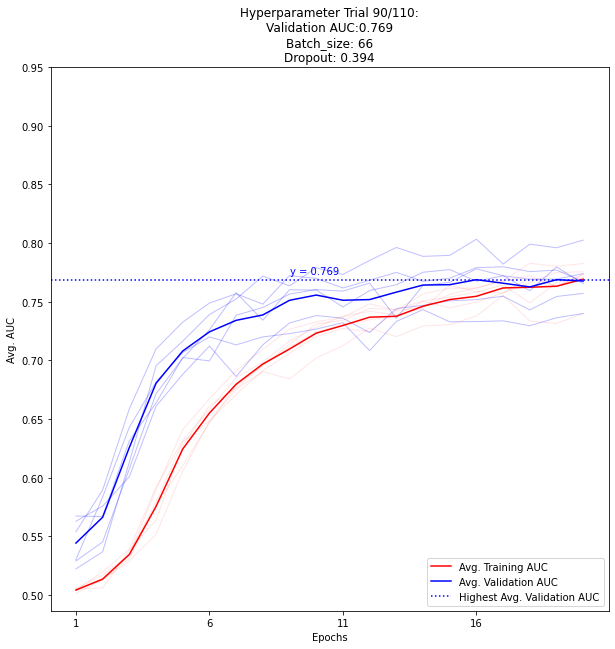

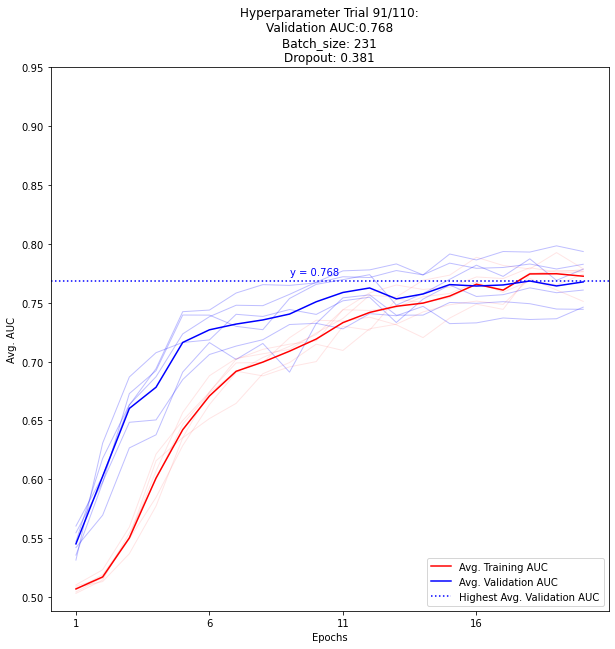

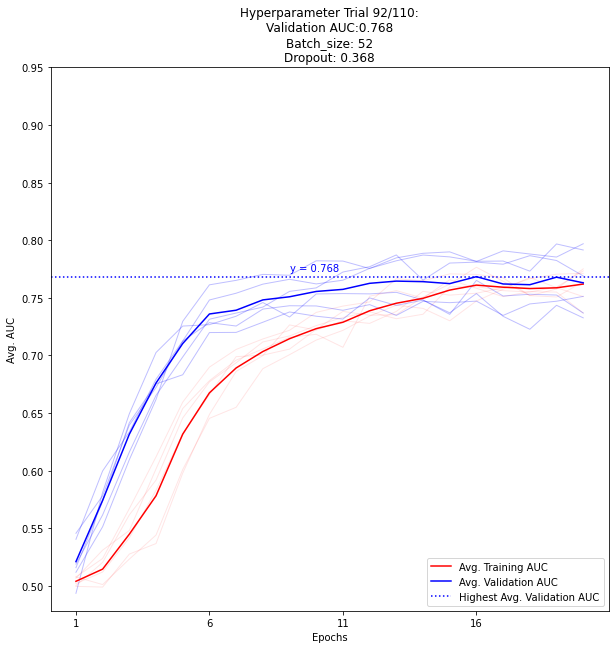

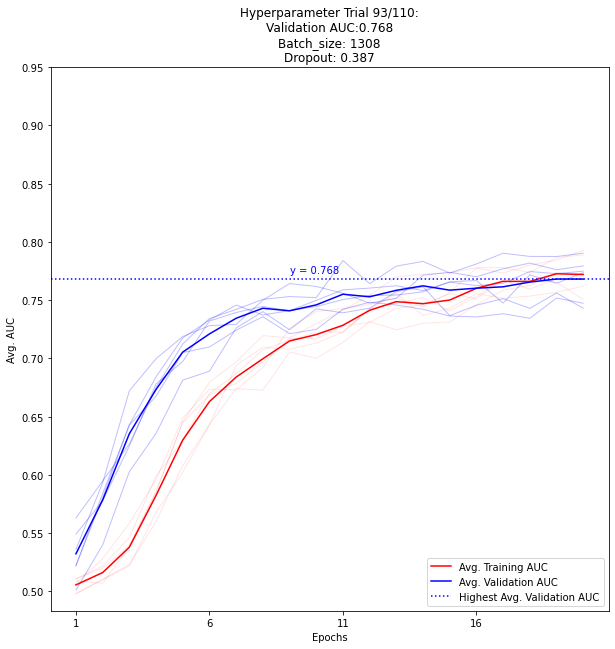

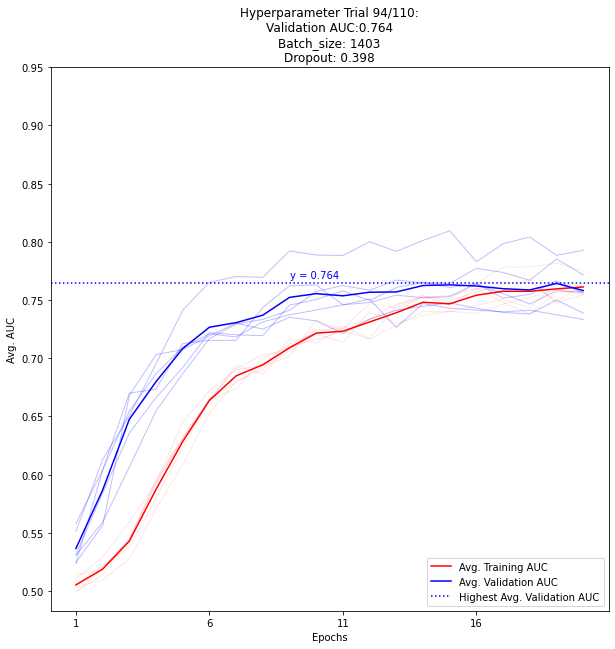

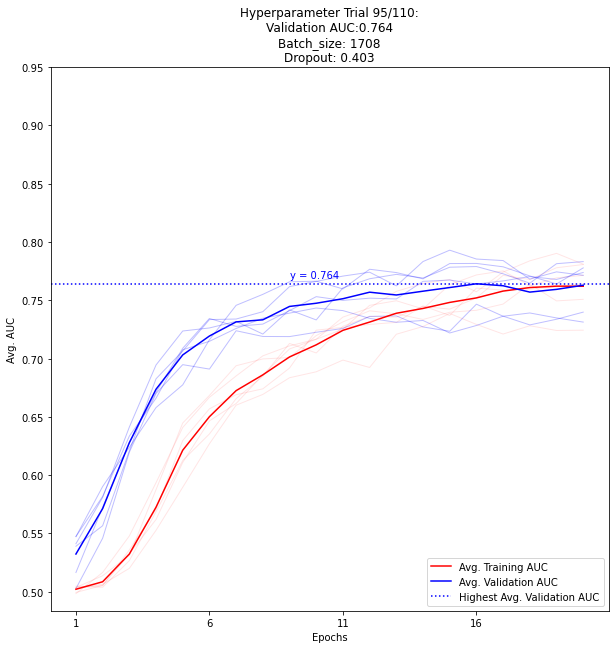

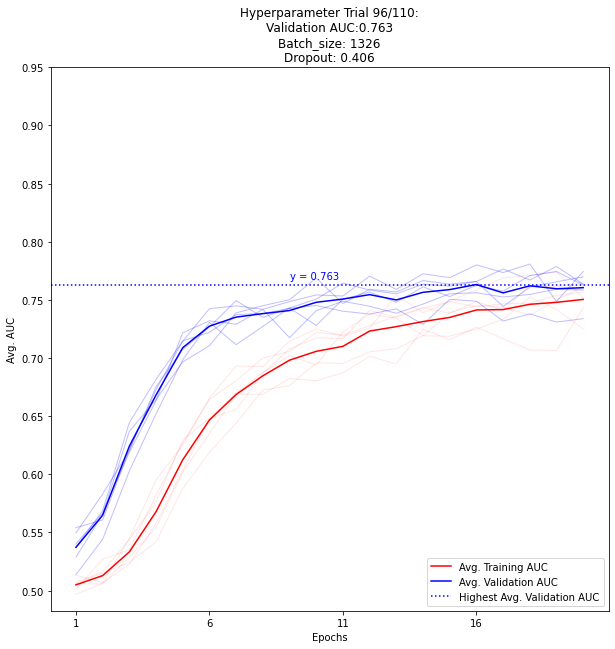

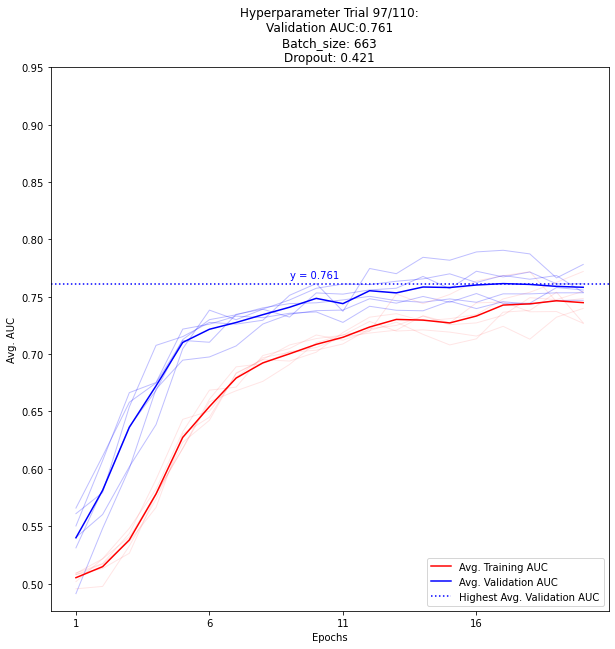

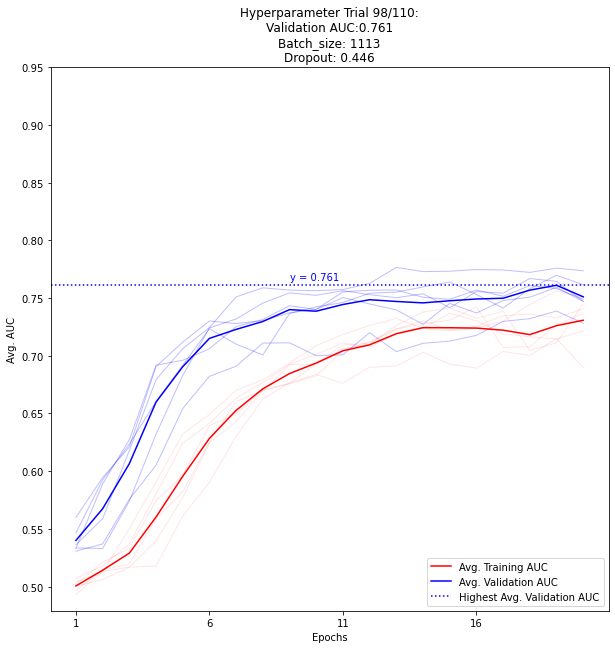

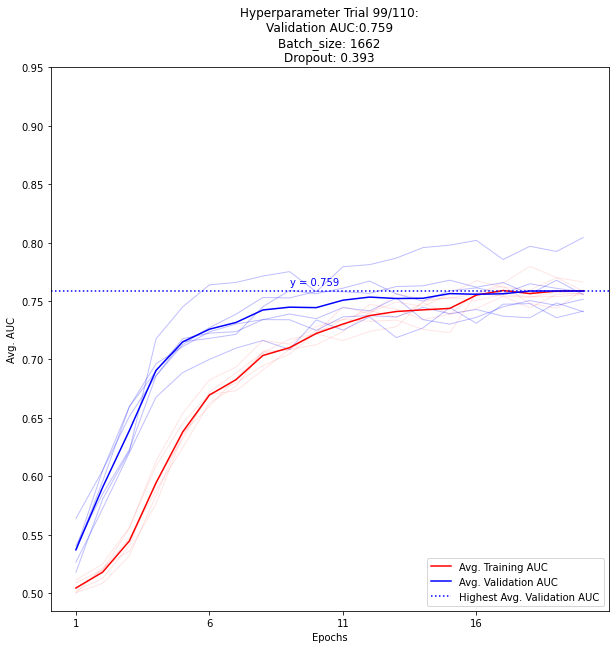

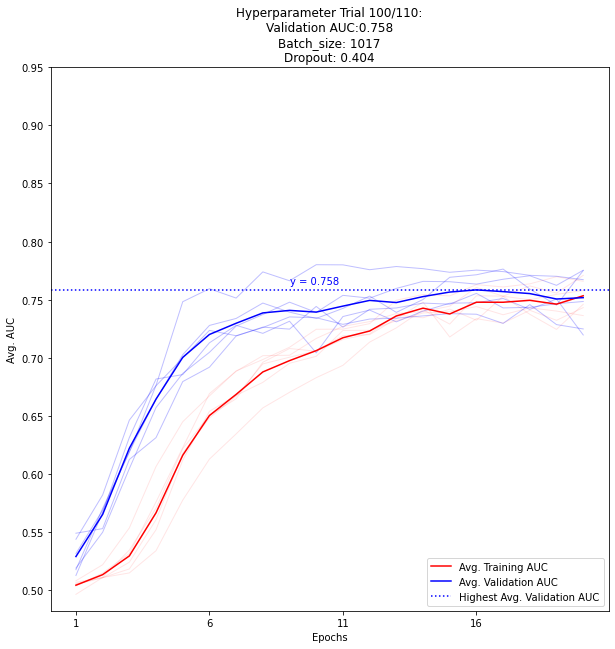

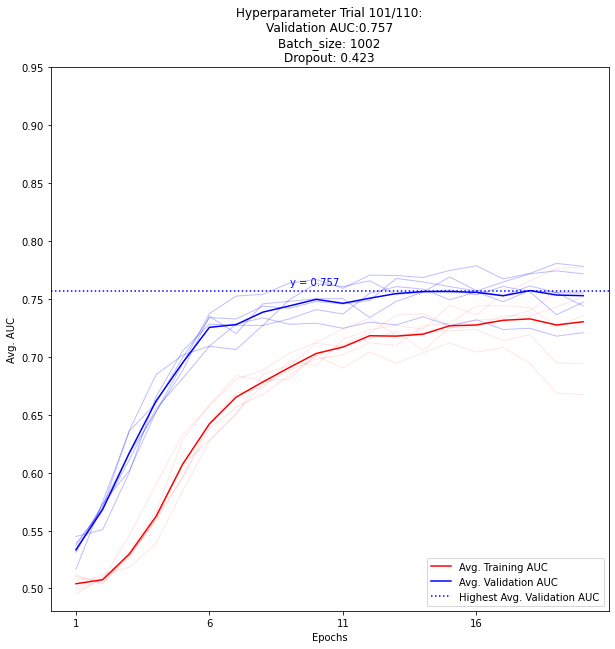

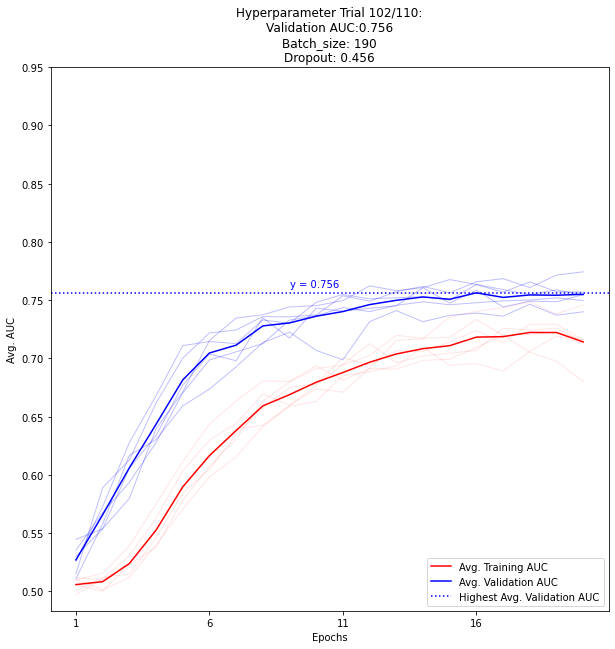

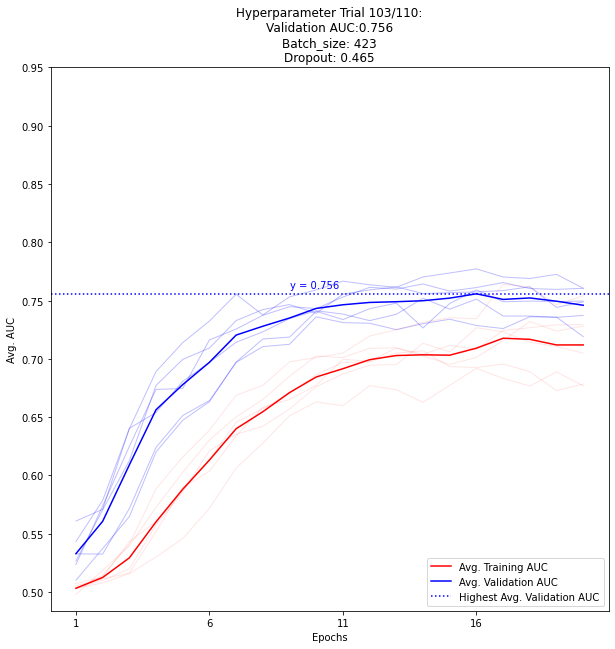

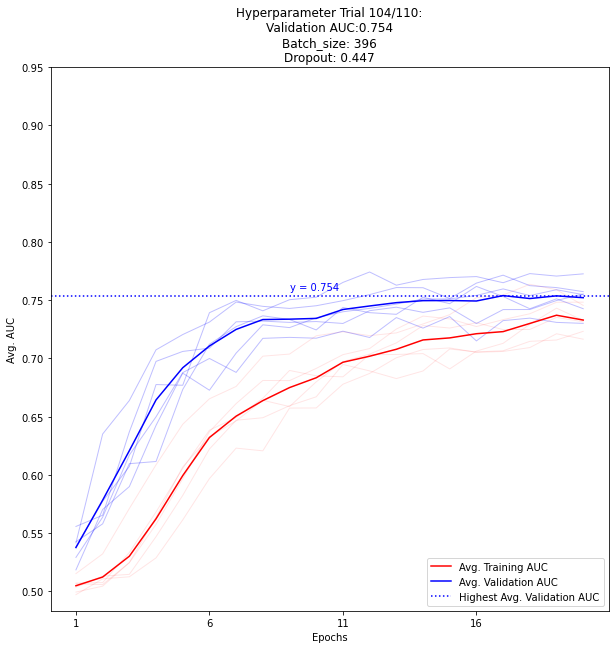

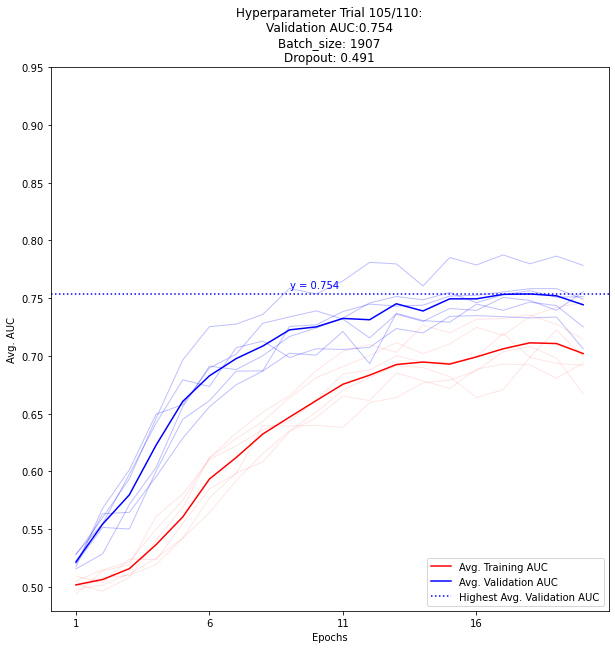

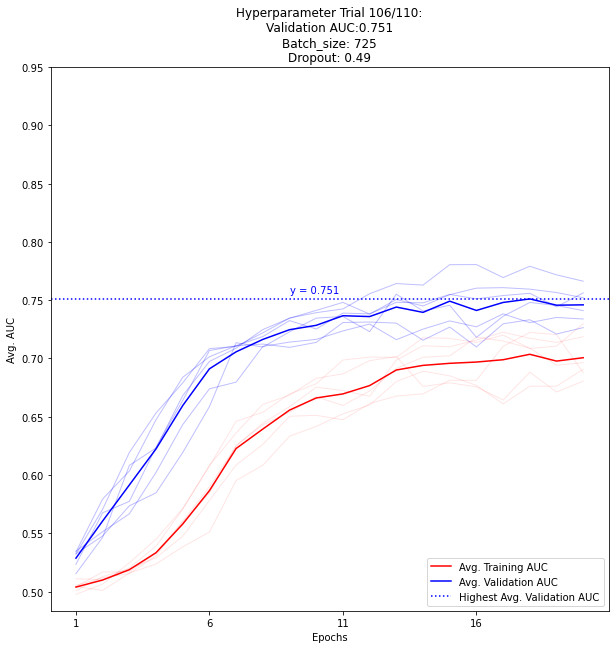

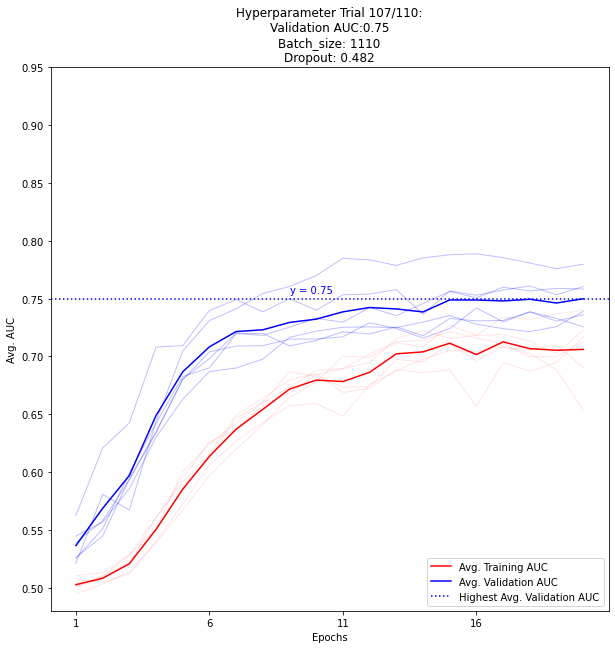

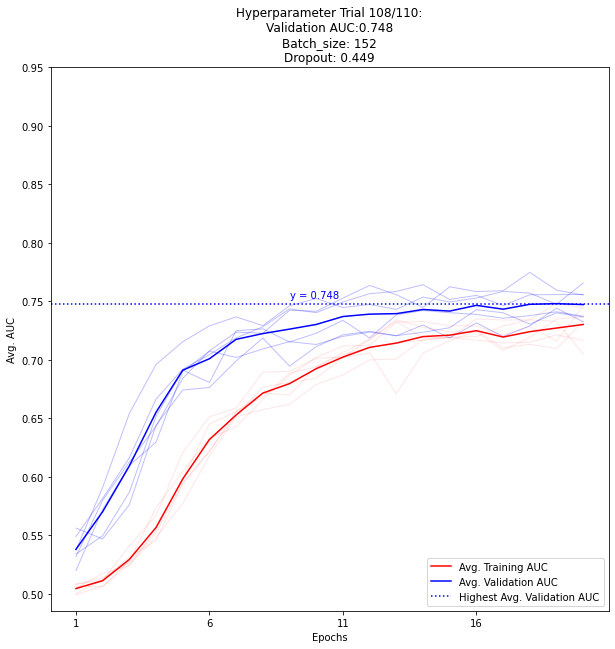

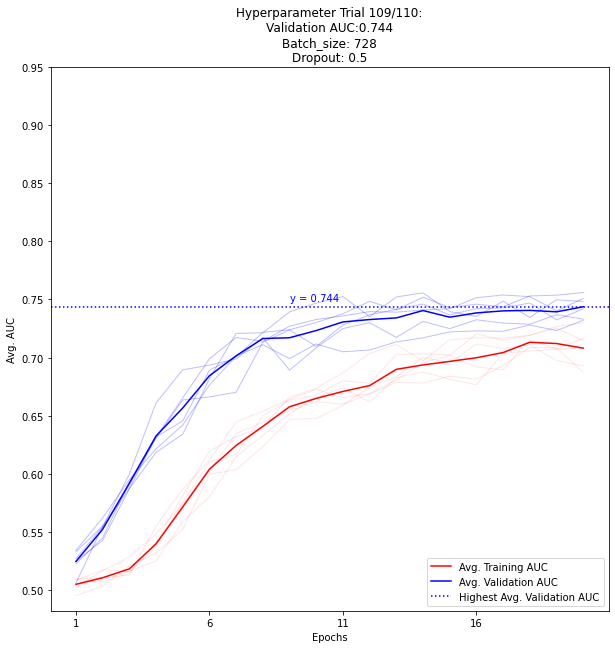

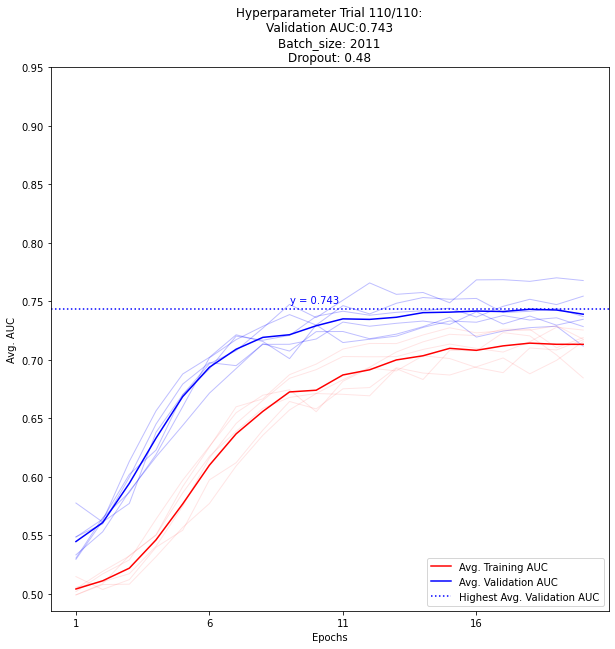

In [7]:
generate_graphs(sorted_metrics)

Write per-trial K-fold cross-validation data out to CSV file. Used to generate raw data for LaTeX graphs.

In [8]:
def generate_kfold_csv_files(sorted_metrics, directory: str = "./") -> None:
    for i, trial in enumerate(sorted_metrics):
        trial_kfold: list[dict[str, float]] = trial['history_list']

        to_csv(trial_kfold, filename=f"{directory}hyper_{i}_valid_auc.csv", metric='val_auc')
        to_csv(trial_kfold, filename=f"{directory}hyper_{i}_train_auc.csv", metric='auc')

Warning: this function generates *a lot* of files, hence be careful where you execute it.

In [9]:
# generate_kfold_csv_files(sorted_metrics)

Write hyperparameter search results out to CSV file. File will be of the format:

* batch_size
* dropout_rate
* max_val_auc.


Likewise used to generate figures in LaTeX.

In [10]:
def generate_hyperparameter_csv_files(sorted_metrics, filename: str = "regime-1.csv", header: bool = True) -> None:
    with open (filename, 'w') as csvfile:
        writer = csv.writer(csvfile)
        if header:
            header: list = ["batch_size", "dropout_rate", "max_val_auc"]
            writer.writerow(header)
        for metric in sorted_metrics:
            csv_row: list = [metric["batch_size"], metric["dropout_rate"], calculate_avg_max(metric["history_list"])]
            writer.writerow(csv_row)


In [11]:
generate_hyperparameter_csv_files(sorted_metrics)

Plot the hyperparameter search space and AUROC. Likewise this is only for a quick visualisation, actual figures will be built in LaTeX using TiKZ/PGFPlots.

In [12]:
def plot_search_space(filename):
    # Load CSV file into pandas DataFrame
    df = pd.read_csv(filename)

    # Extract values for each column
    batch_sizes = df['batch_size']
    dropout_rates = df['dropout_rate']
    max_val_aucs = df['max_val_auc']

    plt.figure(figsize=(10, 10))

    # Create scatter plot
    plt.scatter(batch_sizes, dropout_rates, c=max_val_aucs, cmap='viridis')

    # Set axis labels and title
    plt.xlabel('Batch Size')
    plt.ylabel('Dropout Rate')
    plt.title('Max Validation AUC by Batch Size and Dropout Rate')

    # Add color bar for scale
    cbar = plt.colorbar()
    cbar.set_label('Max Validation AUC')

    # Show the plot
    plt.show()

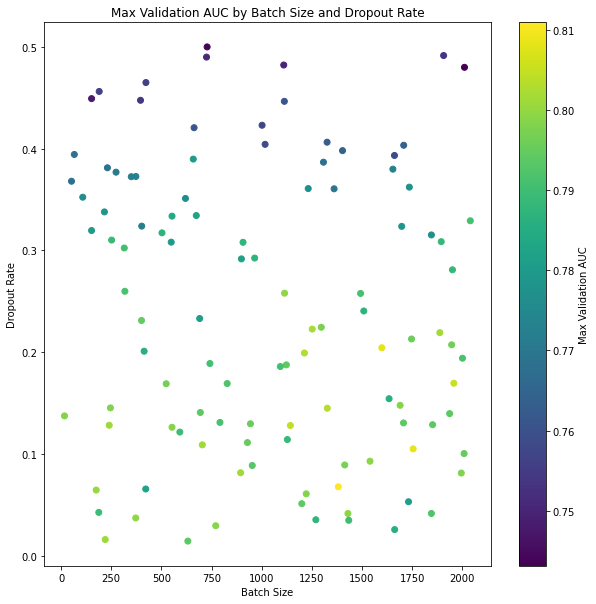

In [13]:
plot_search_space("regime-1.csv")